# setup and imports

In [1]:
import fnmatch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ipywidgets import interactive
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth
import platform

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/paper.mplstyle')

In [2]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/david/Desktop/ALLDATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 34 rats in the data folder


In [3]:
rat_markers = {}
sequence = {}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
               'RatF32': 'normal', 'RatF33': 'normal',
               'RatM31': 'normal', 'RatM32': 'normal',
                'RatF42': 'normal', 'RatM40': 'normal', 'RatM43': 'normal',
                'RatF50': 'DMS', 'RatF51': 'DLS', 'RatF52': 'DLS',
               'RatM50': 'DMS', 'RatM51': 'DMS', 'RatM52': 'DLS', 'RatM53': 'normal', 'RatM54': 'normal'}

markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}


# INTACT RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 'RatM53', 'RatM54']

for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=['silver', 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=['silver', 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    if animal == 'RatM00':
        rat_markers[animal][0] = 'orange'
        
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):

        biglesion = True if 'L' in session else False
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p", biglesion=biglesion)

 

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02


Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF32
Loading data for RatF33
Loading data for RatM31
Loading data for RatM32
Loading data for RatF42
Loading data for RatM40
Loading data for RatM43
Loading data for RatM53
Loading data for RatM54


In [4]:
def round_nearest(x, a=0.04):
    return np.around(x / a) * a

def generate_idle_time(alpha, gamma, N=1, maximum=500, seed=0):
    def p(x, a, g): 
        return a / np.sqrt(2 * np.pi * x ** 3) * np.exp(-((a-g * x) ** 2) / (2 * x))
    def normalization(x, a, g): 
        return simps(p(x, a, g), x)
    x = np.linspace(1e-8, maximum, maximum*100)

    pdf = p(x, alpha, gamma)/normalization(x, alpha, gamma)
    cdf = np.cumsum(pdf); cdf /= max(cdf)

    np.random.seed(seed=seed)
    u = np.random.uniform(0, 1, int(N))
    interp_function = interp1d(cdf, x)
    samples = interp_function(u)
    return samples  #round_nearest(samples)

# Fig Drift

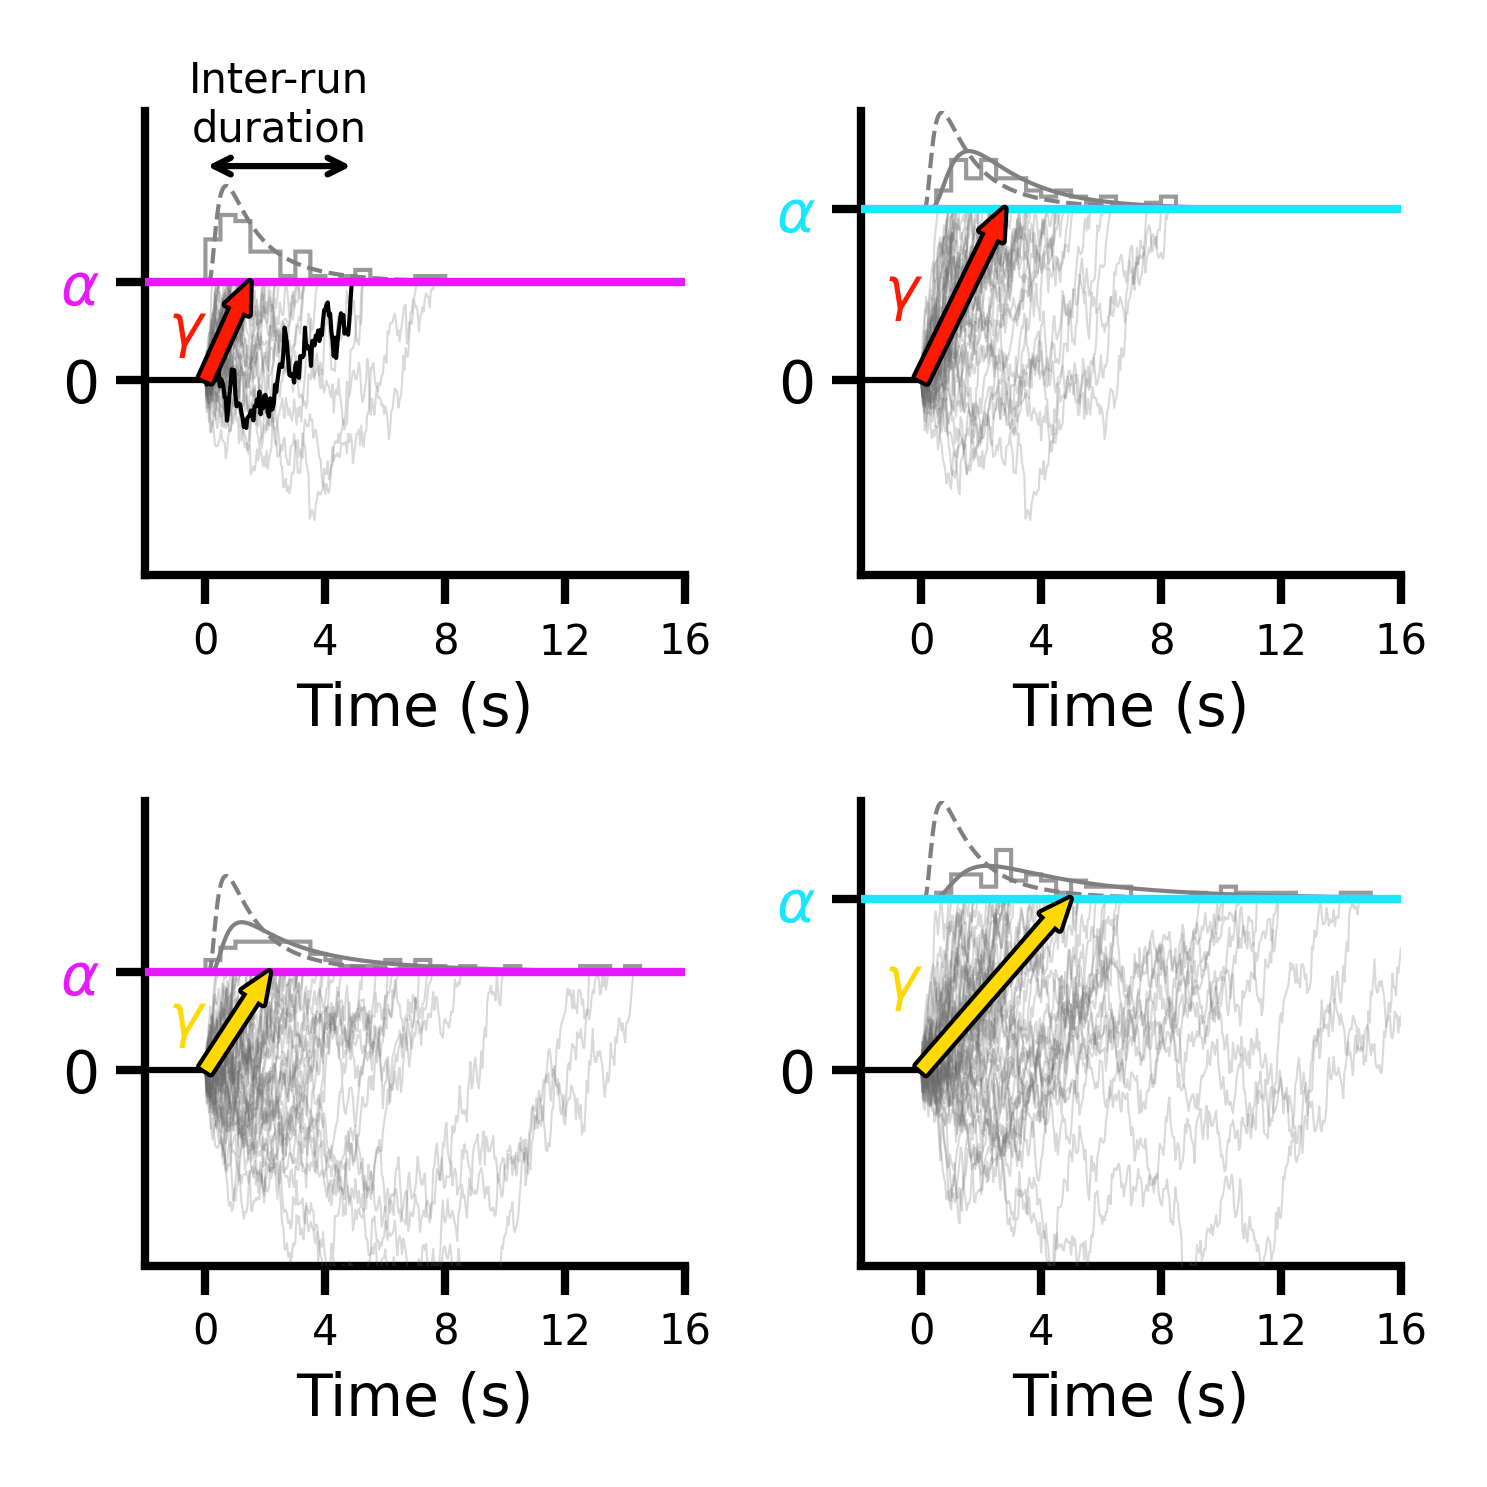

In [5]:
def Figure4_A(ax=None, mean=.2, std=1, A=10, t0=2, N=50, alphacolor='c', gammacolor='r', base=True, xx=None, yy=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    np.random.seed(51)
    trials = [generate_trials(mean, std, A, 0) for _ in range(N)]

    example_plot = True
    for dv in trials:
        dv[-1] = A
        x = np.arange(len(dv))/25
        y = dv
        if base:
            if 4*25 <= len(y) < 5*25 and example_plot:
                ax.plot(x, y, c='k', lw=0.5, zorder=4)
                example_plot = False

                # idle time arrow
                ax.annotate(text='', xy=(-.5, 17.5), xytext=(len(y)/25+.5, 17.5), arrowprops=dict(arrowstyle='<->', lw=0.75), fontsize=5, zorder=5)
                ax.annotate(text='Inter-run\nduration', xy=(0, 0), xytext=(len(y)/50, 22.5), ha='center', va='center',
                            xycoords='data', fontsize=5, zorder=5)
                
        ax.plot(x, y, c='dimgray', alpha=.25, zorder=3, lw=.25,)

    waits = np.array([len(t)/25 for t in trials], dtype=np.float64)

    waitmean = A / mean * np.tanh(mean * A)  #  + t0
    ax.axhline(A, c=alphacolor, zorder=5, lw=1)
    ax.set_yticks([0, A])
    ax.set_yticklabels([0, r'$\alpha$'], fontsize=7)
    ax.get_yticklabels()[1].set_color(alphacolor)
    ax.set_xlabel('Time (s)')
    ax.set_ylim(-16, 22)
    ax.set_xlim(-2, 16)
    ax.set_xticks([0, 4, 8, 12, 16])
    ax.plot((0, -t0), (0, 0), c="k", zorder=5, lw=.75)
    # space_axes(ax)


    # gamma arrow
    # ax.text(waitmean/50-1, A/2, r'$\gamma$', ha="center", va="center", rotation=0, size=7, color=gammacolor, zorder=5)
    ax.text(-0.6, A/2, r'$\gamma$', ha="center", va="center", rotation=0, size=7, color=gammacolor, zorder=5)
    style = "Simple, head_width=.1, tail_width=0.05, head_length=.12"
    kw = dict(arrowstyle=style)
    ax.add_patch(mpatches.FancyArrowPatch((0, 0), (waitmean/25, A),
                                           shrinkA=0, shrinkB=0, edgecolor='k',
                                            mutation_scale=30, 
                                            lw=1, zorder=9, **kw))
    
    ax.add_patch(mpatches.FancyArrowPatch((0, 0), (waitmean/25, A),
                                           shrinkA=0, shrinkB=0,
                                            mutation_scale=30, 
                                            color=gammacolor, 
                                            lw=0, zorder=10, **kw))
    
    mx = 300
    bins = np.arange(0, mx+1, .5)
    ax.hist(waits, bins=bins, color='gray',
             alpha=.8, zorder=4, histtype="step", lw=.5,
             bottom=A,
             weights=np.ones_like(waits) / len(waits) *25,
             )
    
    p, _ = wald_fit(waits)
    x = np.linspace(0.01, 20, 1000)

    if base:
        ax.plot(x, A+Wald_pdf(x, *p)*15, 'gray', lw=.5, ls='--')
        return x, Wald_pdf(x, *p)*15
    else:
        ax.plot(x, A+Wald_pdf(x, *p)*15, 'gray', lw=.5)
        ax.plot(xx, A+yy, c='gray', lw=.5, ls='--')


fig, axs = plt.subplots(2, 2, figsize=(cm2inch(6), cm2inch(6)), dpi=600)
x, y = Figure4_A(ax=axs[0, 0], A=8, mean=.2, base=True, alphacolor=plt.get_cmap('cool_r')(0.1), 
                 gammacolor=plt.get_cmap('autumn')(0.1))

Figure4_A(ax=axs[0, 1], A=14, mean=.2, base=False, alphacolor=plt.get_cmap('cool_r')(0.9), 
          gammacolor=plt.get_cmap('autumn')(0.1), xx=x, yy=y)
Figure4_A(ax=axs[1, 0], A=8, mean=.1, base=False, alphacolor=plt.get_cmap('cool_r')(0.1), 
          gammacolor=plt.get_cmap('autumn')(0.85), xx=x, yy=y)
Figure4_A(ax=axs[1, 1], A=14, mean=.1, base=False, alphacolor=plt.get_cmap('cool_r')(0.9), 
          gammacolor=plt.get_cmap('autumn')(0.85), xx=x, yy=y)

# x, y, l, h = axs[0, 0].get_position().bounds
# print(x, y, l, h)
# plot_wald_overlay(w1, ax=fig.add_axes([x, y, l, h]))

# 4A $\alpha_0 \gamma_0$

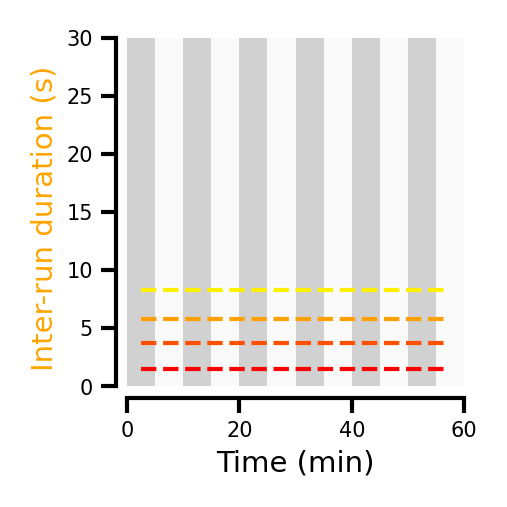

In [6]:
# plot variable median/mean fir each block
def Figure4A(ax=None, cmap=plt.get_cmap('autumn'), reverse=False, hide_xlabel=False, hide_ylabel=False):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75]
    modifs = [-1.25, 1, 3, 5.5]
    if reverse:
        modifs = modifs[::-1]
    cmap = cmap
    for idx, modif in enumerate(modifs):
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + modif for i in range(0, len(blocks))],
                color=cmap((1.25*idx)/len(modifs)), ls='--')

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    if not hide_xlabel:
        ax.set_xlabel("Time (min)")
    if not hide_ylabel:
        ax.set_ylabel("Inter-run duration (s)", color='orange')
    ax.set_xlim(0, 60)
    ax.set_xticks([0, 20, 40, 60])
    ax.set_ylim(0, 30)
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure4A(ax=ax)

# 4B  $\alpha_t \gamma_t$

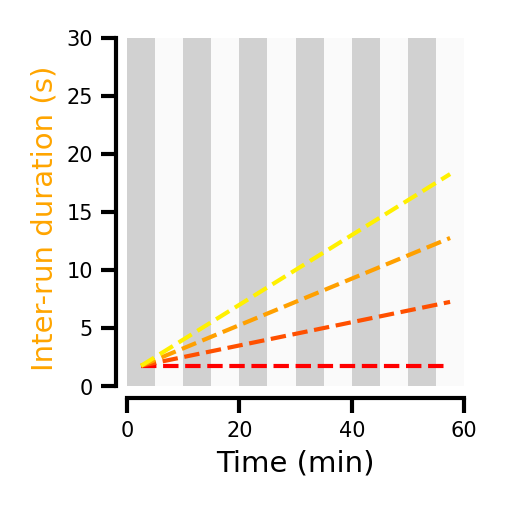

In [7]:
# plot variable median/mean fir each block
def Figure4B(ax=None, cmap=plt.get_cmap('autumn'), reverse=False, hide_xlabel=False, hide_ylabel=False):

    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
    modifs = [0, 0.5, 1, 1.5]
    if reverse:
        modifs = modifs[::-1]
    cmap = cmap
    
    for idx, modif in enumerate(modifs):
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + (i*modif) for i in range(0, len(blocks))],
                color=cmap((1.25*idx)/len(modifs)), ls='--')

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    if not hide_xlabel:
        ax.set_xlabel("Time (min)")
    if not hide_ylabel:
        ax.set_ylabel("Inter-run duration (s)", color='orange')
    ax.set_xticks([0, 20, 40, 60])
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 30)
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure4B(ax=ax)

# 4C  $\alpha_u \gamma_u$

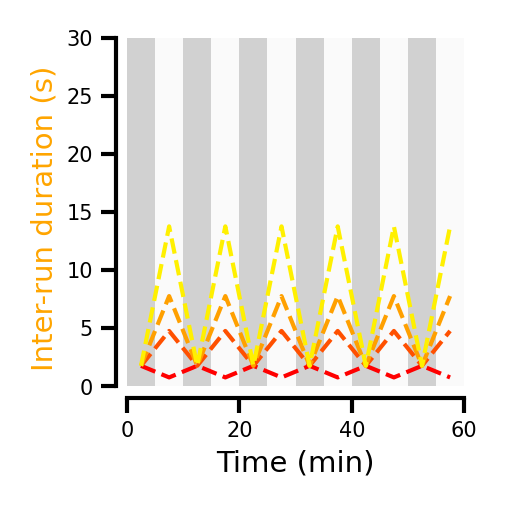

In [8]:
# plot variable median/mean fir each block
def Figure4C(ax=None, cmap=plt.get_cmap('autumn'), reverse=False, hide_xlabel=False, hide_ylabel=False):

    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
    modifs = [-1, 3, 6, 12]
    if reverse:
        modifs = modifs[::-1]
    cmap = cmap
    for idx, modif in enumerate(modifs):
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + modif if i % 2 == 1 else dummy_data[i] for i in range(0, len(blocks)) ],
                color=cmap((1.25*idx)/len(modifs)), ls='--')

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)

    if not hide_xlabel:
        ax.set_xlabel("Time (min)")
    if not hide_ylabel:
        ax.set_ylabel("Inter-run duration (s)", color='orange')
    ax.set_xticks([0, 20, 40, 60])
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 30)
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure4C(ax=ax)

/home/david/Desktop/code/VIGOR_MODELS_Functions.py:590: RuntimeWarning: divide by zero encountered in true_divide
  res = alpha / np.sqrt(arg) * np.exp(-((alpha-gamma * x) ** 2) / (2 * x))
/home/david/Desktop/code/VIGOR_MODELS_Functions.py:590: RuntimeWarning: invalid value encountered in multiply
  res = alpha / np.sqrt(arg) * np.exp(-((alpha-gamma * x) ** 2) / (2 * x))


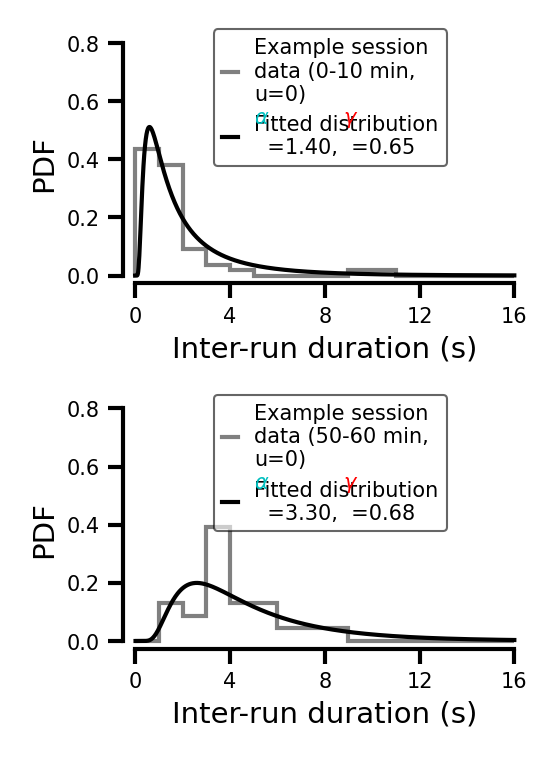

In [9]:
def wald_fit(x, alpha_init=2, theta_init=0, gamma_init=.5):
    """fit Wald distribution"""
    params_init = np.array([alpha_init, theta_init, gamma_init])
    res = minimize(crit, params_init, args=x, bounds=((0, 5), (0, 1e-8), (0, 1)))
    return res.x, res.fun

def plot_distribution_idle(ax=None, timebin=0, historybin=0):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    animal='RatM00'
    session='RatM00_2021_07_22_16_13_03'

    idletimes = prepare_data_idle_times(sequence, [animal], [session])
    idletimes = idletimes[animal][timebin][historybin]
    # print(idletimes)


    # idletimes = [item for sublist in prepare_data_idle_times(sequence, [animal], [session])[animal][timebin] for item in sublist]

    bins=np.linspace(0, 16, 17)
    ydata, xdata, _ = ax.hist(idletimes, bins=bins,
                    color='gray', zorder=4, lw=1,
                    density=True,
                    weights=np.ones_like(idletimes) / len(idletimes),
                    histtype="step")

    ax.plot([-10, -11], [-10, -11], c='gray', lw=1, label=f"Example session\ndata ({timebin*10}-{(timebin+1)*10} min,\nu=0)")
    
    x = np.linspace(0, 16, 1000)
    p, _ = wald_fit(idletimes)
    y = Wald_pdf(x, *p)

    ax.plot(x, y, zorder=10, lw=1, c='k', label=f"Fitted distribution\n  ={p[0]:.2f},  ={p[2]:.2f}")
    ax.text(5, 0.525, r'$\alpha$', fontsize=5, color='c', zorder=10)
    ax.text(8.75, 0.525, r'$\gamma$', fontsize=5, color='r', zorder=10)


    ax.set_xlim(0, 16)
    ax.set_xticks([0, 4, 8, 12, 16])
    ax.set_ylim(0, .8)
    ax.set_yticks([0, .2, .4, .6, .8])
    ax.set_xlabel('Inter-run duration (s)')
    ax.set_ylabel('PDF')

    space_axes(ax)
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(.2, 1.1),
                frameon=True, fontsize=5, markerscale=1, handlelength=.75, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)
    


# fig, axs = plt.subplots(1, 2, figsize=(cm2inch((18/5)*2), cm2inch(11/3)),)
fig, axs = plt.subplots(2, 1, figsize=(cm2inch((4.425)), cm2inch(3.063*2)),)
plot_distribution_idle(axs[0], timebin=0, historybin=0)
plot_distribution_idle(axs[1], timebin=5, historybin=0)


# handles, labels = axs[0].get_legend_handles_labels()
# unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
# axs[0].legend(*zip(*unique), loc='best', handletextpad=0.25,
#                 frameon=True, fontsize=5, markerscale=1, handlelength=.75, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

# handles, labels = axs[1].get_legend_handles_labels()
# unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
# axs[1].legend(*zip(*unique), loc='best',
#                 frameon=True, fontsize=5, markerscale=1, handlelength=.75, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)





# 4D model + data

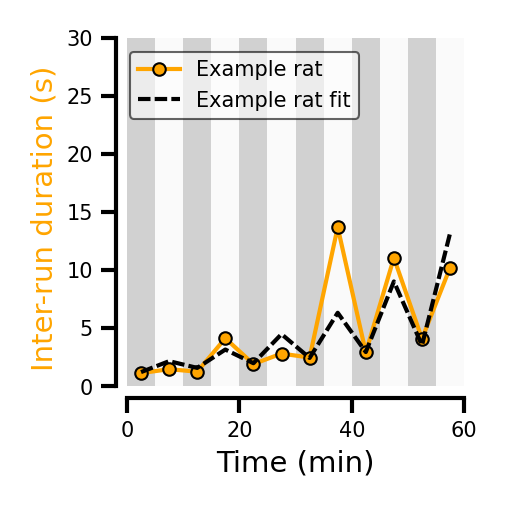

In [10]:
# plot variable median/mean fir each block, example session example rat
def Figure4D(ax=None):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.25, 2.25, 1.5, 2.75, 2, 3.5, 2.4, 4.2, 3.2, 5.2, 3.5, 6.3]
    # ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
    #         [dummy_data[i] for i in range(0, len(blocks))],  # or use median
    #         color='orange', 
    #         zorder=4, markeredgecolor='k', markeredgewidth=0.5,
    #         ls='--', label='Synthetic data')
    
    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Inter-run duration (s)", color='orange')
    ax.set_xlim(0, 60)
    ax.set_xticks([0, 20, 40, 60])
    ax.set_ylim(0, 30)
    # ax.set_yticks([0, 5, 10, 15])
    space_axes(ax)


    # experimental rat data

    root = "/home/david/Desktop/ALLDATA"
    animal='RatM00'
    session='RatM00_2021_07_22_16_13_03'

    _params = get_from_pickle(root, animal, session, name="params.p")
    blocks = _params['blocks']
    rewardProbaBlock = _params['rewardProbaBlock']
    example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeinZone.p")
    data = [example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
            [np.median(data[i]) for i in range(0, len(blocks))],
            marker='o', ms=3, color='orange', 
            zorder=4, markeredgecolor='k', markeredgewidth=0.5, alpha=1, label='Example rat')



    # fit, generate samples from distribution with fit parameters, take median
    N_bins = 6
    N_avg = 4
    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ALPHA = np.zeros((N_bins, N_avg))
    GAMMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            ALPHA[bin, avg] = ex_alpha + bin*ex_alpha_t + avg*ex_alpha_u
            GAMMA[bin, avg] = ex_gamma + bin*ex_gamma_t + avg*ex_gamma_u

    a = []
    g = []
    for i in range(6):
        a.append(.9*ALPHA[i][0]+0.1*ALPHA[i][1])
        a.append(.9*ALPHA[i][-1]+0.1*ALPHA[i][-2])
        g.append(.9*GAMMA[i][0]+0.1*GAMMA[i][1])
        g.append(.9*GAMMA[i][-1]+0.1*GAMMA[i][-2])

    res = [np.median(generate_idle_time(a[i], g[i], 1000)) for i in range(12)]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            [res[i] for i in range(0, len(blocks))],  # or use median
            color='k', ls=(0, (3, 1)), label='Example rat fit', zorder=5)


    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure4D(ax=ax)

[3.55374529 5.04976466 3.96000351 ... 5.60650012 0.81693016 6.50718535]
median idle time: 2.10 s
error: 0.0379 s
error %: 1.80 %


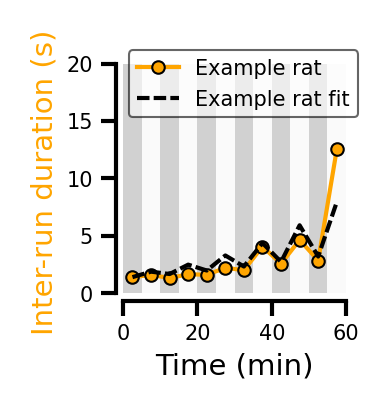

In [11]:
# plot variable median/mean fir each block, all 120 cm sessions example rat
def _Figure4D(ax=None):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.25, 2.25, 1.5, 2.75, 2, 3.5, 2.4, 4.2, 3.2, 5.2, 3.5, 6.3]
    # ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
    #         [dummy_data[i] for i in range(0, len(blocks))],  # or use median
    #         color='orange', 
    #         zorder=4, markeredgecolor='k', markeredgewidth=0.5,
    #         ls='--', label='Synthetic data')
    
    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Inter-run duration (s)", color='orange')
    ax.set_xlim(0, 60)
    ax.set_xticks([0, 20, 40, 60])
    ax.set_ylim(0, 20)
    # ax.set_yticks([0, 5, 10, 15])
    space_axes(ax)


    # experimental rat data

    root = "/home/david/Desktop/ALLDATA"
    animal='RatM00'
    session='RatM00_2021_07_22_16_13_03'

    _params = get_from_pickle(root, animal, session, name="params.p")
    blocks = _params['blocks']
    rewardProbaBlock = _params['rewardProbaBlock']

    sessions = matchsession(animal, dist120)
    data = [[],[],[],[],[],[],[],[],[],[],[],[]]
    for i, session in enumerate(sessions):
        example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeinZone.p")
        for j in range(0, 12):
            data[j] = np.append(data[j], example_runningTimeInLeftBin[j]+example_runningTimeInRightBin[j])


    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
            [np.median(data[i]) for i in range(0, len(blocks))],
            marker='o', ms=3, color='orange', 
            zorder=4, markeredgecolor='k', markeredgewidth=0.5, alpha=1, label='Example rat')



    # fit, generate samples from distribution with fit parameters, take median
    N_bins = 6
    N_avg = 4
    #ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    
    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u, _, _, _, _, _, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))
    ex_alpha = ex_alpha[animal]['120']
    ex_alpha_t = ex_alpha_t[animal]['120']
    ex_alpha_u = ex_alpha_u[animal]['120']
    ex_gamma = ex_gamma[animal]['120']
    ex_gamma_t = ex_gamma_t[animal]['120']
    ex_gamma_u = ex_gamma_u[animal]['120']

    ALPHA = np.zeros((N_bins, N_avg))
    GAMMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            ALPHA[bin, avg] = ex_alpha + bin*ex_alpha_t + avg*ex_alpha_u
            GAMMA[bin, avg] = ex_gamma + bin*ex_gamma_t + avg*ex_gamma_u

    a = []
    g = []
    for i in range(6):
        a.append(.9*ALPHA[i][0]+0.1*ALPHA[i][1])
        a.append(.9*ALPHA[i][-1]+0.1*ALPHA[i][-2])
        g.append(.9*GAMMA[i][0]+0.1*GAMMA[i][1])
        g.append(.9*GAMMA[i][-1]+0.1*GAMMA[i][-2])

    i = 10
    print(generate_idle_time(a[i], g[i], 10000))
    res = [np.median(generate_idle_time(a[i], g[i], 10000)) for i in range(12)]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            [res[i] for i in range(0, len(blocks))],  # or use median
            color='k', ls=(0, (3, 1)), label='Example rat fit', zorder=5, )

    # error = np.mean(np.sqrt([(np.median(data[i]) - res[i])**2 for i in range(0, len(blocks))]))
    # overall_median = np.median([np.median(data[i]) for i in range(0, len(blocks))])
    # print(f'median crossing time: {overall_median:.2f} s')
    # print(f'error: {error:.2f} s')
    # print(f'error %: {(error/overall_median)*100:.2f} %')

    error = [np.sqrt((np.median(data[i]) - res[i])**2) for i in range(0, len(blocks))]
    total_trials = np.sum([len(data[i]) for i in range(0, len(blocks))])
    weighted_error = [error[i]*len(data[i])/total_trials for i in range(0, len(blocks))]
    error = np.mean(weighted_error)
    overall_median = np.median([np.median(data[i]) for i in range(0, len(blocks))])
    print(f'median idle time: {overall_median:.2f} s')
    print(f'error: {error:.4f} s')
    print(f'error %: {(error/overall_median)*100:.2f} %')


    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 1.1), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(3), cm2inch(3)))
_Figure4D(ax=ax)

# 4FGH fit result dist

In [12]:

def permutation_test_distances(var, shifty=0, h='top', dhs=[0.05, 0.2], barh=.05, ax=None, num_permutations=10000):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    data = np.array([[var[animal][cond] for cond in ['60', '90', '120']] for animal in animalList])
    # p_value_60_90 = exact_mc_perm_paired_test(data[:, 0], data[:, 1])
    # p_value_60_120 = exact_mc_perm_paired_test(data[:, 0], data[:, 2])
    # p_value_90_120 = exact_mc_perm_paired_test(data[:, 1], data[:, 2])

    p_value_60_90 = stats.wilcoxon(data[:, 0], data[:, 1], alternative='two-sided')[1]
    p_value_60_120 = stats.wilcoxon(data[:, 0], data[:, 2], alternative='two-sided')[1]
    p_value_90_120 = stats.wilcoxon(data[:, 1], data[:, 2], alternative='two-sided')[1]



    print(f'p_value_60_90: {p_value_60_90}', f'p_value_60_120: {p_value_60_120}', f'p_value_90_120: {p_value_90_120}')
    if h is 'bottom':
        h = np.min([np.min(data[:, 0]), np.min(data[:, 1]), np.min(data[:, 2])])
        h1, h2, h3 = [h, h, h]
    elif h is 'top':
        h = np.max([np.max(data[:, 0]), np.max(data[:, 1]), np.max(data[:, 2])])
        h1, h2, h3 = [h, h, h]
    else:
        h1, h2, h3 = h
    barplot_annotate_brackets(ax, 0, 1, stars(p_value_60_90), [0, 1, 2], [h1, h1, h1], dh=dhs[0]+shifty, barh=barh, maxasterix=None)
    barplot_annotate_brackets(ax, 0, 2, stars(p_value_60_120), [0, 1, 2], [h2, h2, h2], dh=dhs[1]+shifty, barh=barh, maxasterix=None)
    barplot_annotate_brackets(ax, 1, 2, stars(p_value_90_120), [0, 1, 2], [h3, h3, h3], dh=dhs[0]+shifty, barh=barh, maxasterix=None)

def Figure4H(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [alpha_u[animal]["60"], alpha_u[animal]["90"], alpha_u[animal]["120"]], 
                        color=rat_markers[animal][0], label=f'Individuals (n={len(animalList)})', marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [alpha_u[animal]["60"], alpha_u[animal]["90"], alpha_u[animal]["120"]], 
                        color=rat_markers[animal][0], label='Example rat', marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)


    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_alpha_u, color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.5, .5)
    ax.set_yticks([-0.5, -.25, 0, .25, 0.5])
    ax.set_yticklabels(["-0.5", -.25, "0.0", .25, "0.5"])
    ax.set_ylabel(r'$\alpha_u$')

    # plotmedian(alpha_u, ax=ax, dist_or_tm='dist', do=True)

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    permutation_test_distances(alpha_u, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)

# Figure4H()

In [13]:

def permutation_test_distances(var, shifty=0, h='top', dhs=[0.05, 0.2], barh=.05, ax=None, num_permutations=10000):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    data = np.array([[var[animal][cond] for cond in ['60', '90', '120']] for animal in animalList])
    p_value_60_90 = exact_mc_perm_paired_test(data[:, 0], data[:, 1])
    p_value_60_120 = exact_mc_perm_paired_test(data[:, 0], data[:, 2])
    p_value_90_120 = exact_mc_perm_paired_test(data[:, 1], data[:, 2])

    # p_value_60_90 = stats.wilcoxon(data[:, 0], data[:, 1], alternative='two-sided')[1]
    # p_value_60_120 = stats.wilcoxon(data[:, 0], data[:, 2], alternative='two-sided')[1]
    # p_value_90_120 = stats.wilcoxon(data[:, 1], data[:, 2], alternative='two-sided')[1]



    print(f'p_value_60_90: {p_value_60_90}', f'p_value_60_120: {p_value_60_120}', f'p_value_90_120: {p_value_90_120}')
    if h is 'bottom':
        h = np.min([np.min(data[:, 0]), np.min(data[:, 1]), np.min(data[:, 2])])
        h1, h2, h3 = [h, h, h]
    elif h is 'top':
        h = np.max([np.max(data[:, 0]), np.max(data[:, 1]), np.max(data[:, 2])])
        h1, h2, h3 = [h, h, h]
    else:
        h1, h2, h3 = h
    barplot_annotate_brackets(ax, 0, 1, stars(p_value_60_90), [0, 1, 2], [h1, h1, h1], dh=dhs[0]+shifty, barh=barh, maxasterix=None)
    barplot_annotate_brackets(ax, 0, 2, stars(p_value_60_120), [0, 1, 2], [h2, h2, h2], dh=dhs[1]+shifty, barh=barh, maxasterix=None)
    barplot_annotate_brackets(ax, 1, 2, stars(p_value_90_120), [0, 1, 2], [h3, h3, h3], dh=dhs[0]+shifty, barh=barh, maxasterix=None)



def permutation_test_vbelt(var, shifty=0, h='top', dhs=[0.05, 0.2], xs=[0, 2, 4], barh=.05, ax=None, num_permutations=10000):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    data = np.array([[var[animal][cond] for cond in ['20', '2', 'rev20']] for animal in animalList])
    p_value_20_2 = exact_mc_perm_paired_test(data[:, 0], data[:, 1])
    p_value_2_rev20 = exact_mc_perm_paired_test(data[:, 1], data[:, 2])
    p_value_20_rev20 = exact_mc_perm_paired_test(data[:, 0], data[:, 2])

    # p_value_20_2 = stats.wilcoxon(data[:, 0], data[:, 1])[1]
    # p_value_2_rev20 = stats.wilcoxon(data[:, 1], data[:, 2])[1]
    # p_value_20_rev20 = stats.wilcoxon(data[:, 0], data[:, 2])[1]

    print(f'p_value_20_0: {p_value_20_2}', f'p_value_0_rev20: {p_value_2_rev20}', f'p_value_20_rev20: {p_value_20_rev20}')
    if h is None:
        h = np.min([np.min(data[:, 0]), np.min(data[:, 1]), np.min(data[:, 2])])
        h1, h2, h3 = [h, h, h]
    elif h is 'top':
        h = np.max([np.max(data[:, 0]), np.max(data[:, 1]), np.max(data[:, 2])])
        h1, h2, h3 = [h, h, h]
    else:
        h1, h2, h3 = h
    barplot_annotate_brackets(ax, 0, 1, stars(p_value_20_2), xs, [h1, h1, h1], dh=dhs[0]+shifty, barh=barh, maxasterix=None)
    barplot_annotate_brackets(ax, 1, 2, stars(p_value_2_rev20), xs, [h2, h2, h2], dh=dhs[0]+shifty, barh=barh, maxasterix=None)
    barplot_annotate_brackets(ax, 0, 2, stars(p_value_20_rev20), xs, [h3, h3, h3], dh=dhs[1]+shifty, barh=barh, maxasterix=None)


def Figure4H(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 3))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 2], [alpha_t[animal]["60"], alpha_t[animal]["120"]], 
                        color=rat_markers[animal][0], label=f'Individuals (n={len(animalList)})', marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 2], [alpha_t[animal]["60"], alpha_t[animal]["120"]], 
                        color=rat_markers[animal][0], label='Example rat', marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)


 
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.25, .6)
    ax.set_yticks([-.25, 0, .25, 0.5])
    # ax.set_yticklabels(["-0.5", -.25, "0.0", .25, "0.5"])
    ax.set_ylabel(r'$\alpha_t$')

    # plotmedian(alpha_t, ax=ax, dist_or_tm='dist', do=True)

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    permutation_test_distances(alpha_t, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)

# Figure4H()

In [14]:
def Figure4L(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 3))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 4], [alpha_0[animal]["20"], alpha_0[animal]["rev20"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], label='Individuals')
        
        if animal == 'RatM00':
            ax.plot([0, 4], [alpha_0[animal]["20"], alpha_0[animal]["rev20"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5, label='Example rat')

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 4,])
    ax.set_xticklabels(["20","-20"])
    _ = r'$v_{belt}$'
    if show_xlabel:
        ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(0, 3)
    ax.set_ylabel(r'$\alpha_0$')

    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    permutation_test_vbelt(alpha_0, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)


# Figure4L()

In [15]:
def Figure4P(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 3))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 2, 4], [gamma_t[animal]["20"], gamma_t[animal]["2"], gamma_t[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatM00':
            ax.plot([0, 2, 4], [gamma_t[animal]["20"], gamma_t[animal]["2"], gamma_t[animal]["rev20"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{belt}$'
    if show_xlabel:
        ax.set_xlabel(f'{_} (cm/s)')


    # plotmedian(gamma_t, ax=ax, dist_or_tm='tm')

    ax.set_ylim(-0.2, 0.1)
    ax.set_ylabel(r'$\gamma_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    permutation_test_vbelt(gamma_t, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, shifty=0.05, num_permutations=10000)

# Figure4P()

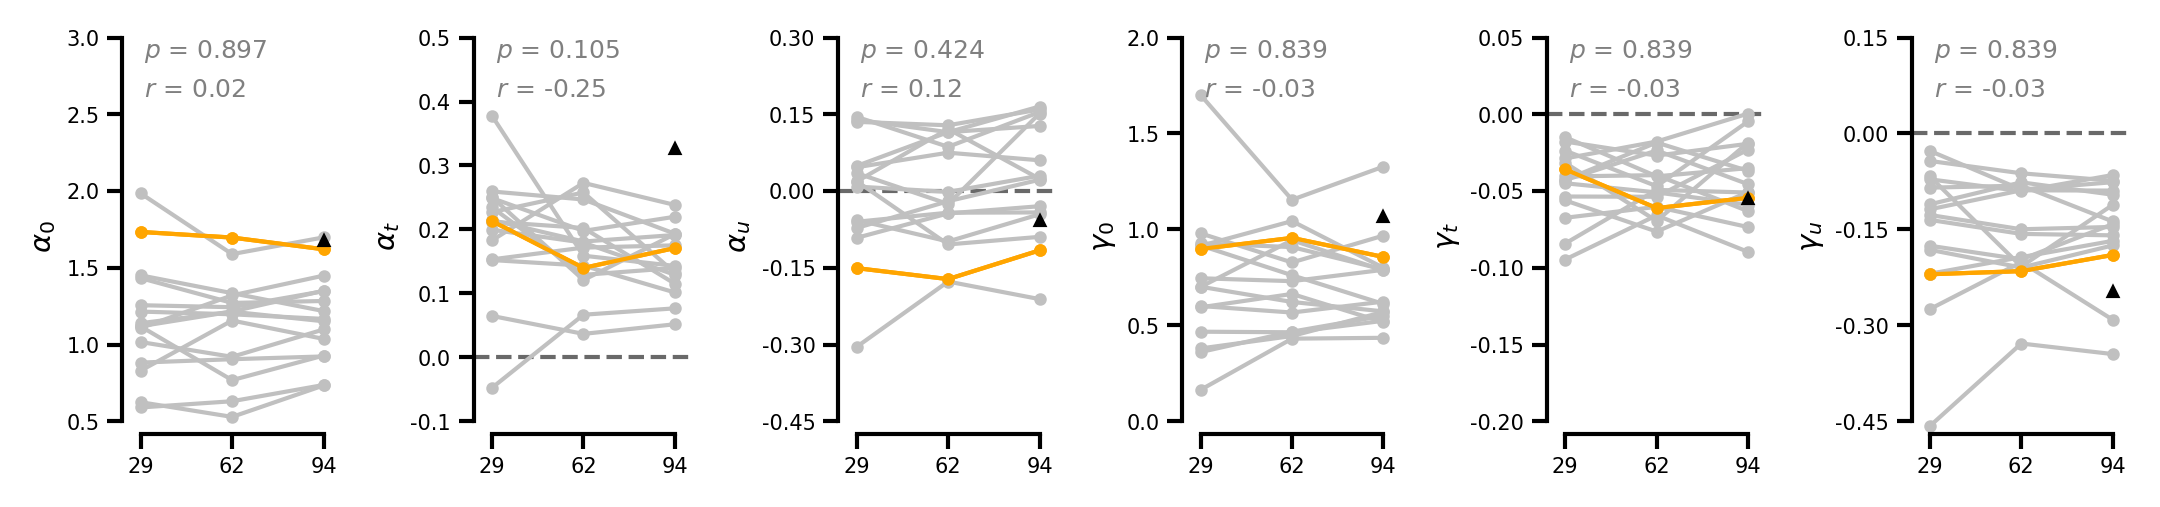

In [16]:
def Figure4F(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [alpha_0[animal]["60"], alpha_0[animal]["90"], alpha_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [alpha_0[animal]["60"], alpha_0[animal]["90"], alpha_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5, label='Example rat')

    
    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_alpha, color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(0.5, 3)
    ax.set_yticks([0.5, 1, 1.5, 2, 2.5, 3])
    ax.set_ylabel(r'$\alpha_0$')
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    r, p_value = regression_permutation(alpha_0, dist_or_tm='dist')
    annotate_regression(p_value, r, ax)
    # permutation_test_distances(alpha_0, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)


def Figure4G(ax=None,show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [alpha_t[animal]["60"], alpha_t[animal]["90"], alpha_t[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatM00':
            ax.plot([0, 1, 2], [alpha_t[animal]["60"], alpha_t[animal]["90"], alpha_t[animal]["120"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    
    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_alpha_t, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    


    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-.1, .5)
    ax.set_yticks([-.1, 0, .1, .2, .3, .4, .5])
    ax.set_ylabel(r'$\alpha_t$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_distances(alpha_t, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)
    r, p_value = regression_permutation(alpha_t, dist_or_tm='dist')
    annotate_regression(p_value, r, ax)

def Figure4H(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [alpha_u[animal]["60"], alpha_u[animal]["90"], alpha_u[animal]["120"]], 
                        color=rat_markers[animal][0], label=f'Individuals (n={len(animalList)})', marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [alpha_u[animal]["60"], alpha_u[animal]["90"], alpha_u[animal]["120"]], 
                        color=rat_markers[animal][0], label='Example rat', marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)


    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_alpha_u, color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.45, .30)
    ax.set_yticks([-0.45, -.30, -.15, 0, 0.15, .30])
    ax.set_ylabel(r'$\alpha_u$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_distances(alpha_u, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)
    r, p_value = regression_permutation(alpha_u, dist_or_tm='dist')
    annotate_regression(p_value, r, ax)

def Figure4I(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [gamma_0[animal]["60"], gamma_0[animal]["90"], gamma_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], label='Individuals')
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [gamma_0[animal]["60"], gamma_0[animal]["90"], gamma_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5, label='Example rat')

    
    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_gamma, color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(0, 2)
    ax.set_yticks([0, 0.5, 1, 1.5, 2])
    ax.set_ylabel(r'$\gamma_0$')
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_distances(gamma_0, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)
    r, p_value = regression_permutation(gamma_0, dist_or_tm='dist')
    annotate_regression(p_value, r, ax)

def Figure4J(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [gamma_t[animal]["60"], gamma_t[animal]["90"], gamma_t[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatM00':
            ax.plot([0, 1, 2], [gamma_t[animal]["60"], gamma_t[animal]["90"], gamma_t[animal]["120"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    

    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_gamma_t, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    

    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.2, 0.05)
    ax.set_yticks([-0.2, -.15, -.1, -.05, 0, 0.05])
    ax.set_ylabel(r'$\gamma_t$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_distances(gamma_t, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, shifty=0.05, num_permutations=10000)
    r, p_value = regression_permutation(gamma_0, dist_or_tm='dist')
    annotate_regression(p_value, r, ax)

def Figure4K(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [gamma_u[animal]["60"], gamma_u[animal]["90"], gamma_u[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [gamma_u[animal]["60"], gamma_u[animal]["90"], gamma_u[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_gamma_u, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.45, 0.15)
    ax.set_yticks([-.45, -.3, -.15, 0, .15])
    ax.set_ylabel(r'$\gamma_u$')
    
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_distances(gamma_u, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, shifty=0.05, num_permutations=10000)
    r, p_value = regression_permutation(gamma_0, dist_or_tm='dist')
    annotate_regression(p_value, r, ax)

fig, axs = plt.subplots(1, 6, figsize=(cm2inch(18), cm2inch(4)))
Figure4F(axs[0])
Figure4G(axs[1])
Figure4H(axs[2])
Figure4I(axs[3])
Figure4J(axs[4])
Figure4K(axs[5])


# # This is a hack to get the legend to not mess up the spacing
# handles, labels = axs[0].get_legend_handles_labels()
# unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
# fig.legend(*zip(*unique), loc='upper center',# bbox_to_anchor=(0.01, 0.99), 
#                             frameon=False, fontsize=5, markerscale=1, 
#                             edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

In [17]:
def plotmedian(var, ax=None, dist_or_tm='dist', do=True):
    if do:
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
        if dist_or_tm == 'dist':
            ax.plot([0, 1, 2], [np.median([var[animal]["60"] for animal in animalList]), 
                                np.median([var[animal]["90"] for animal in animalList]),
                                np.median([var[animal]["120"] for animal in animalList])],
                                color='k', label=f'Median (n={len(animalList)})')
        elif dist_or_tm == 'tm':
            ax.plot([0, 1, 2, 3, 4], [np.median([var[animal]["20"] for animal in animalList]), 
                                np.median([var[animal]["10"] for animal in animalList]),
                                np.median([var[animal]["2"] for animal in animalList]),
                                np.median([var[animal]["rev10"] for animal in animalList]),
                                np.median([var[animal]["rev20"] for animal in animalList])],
                                color='k')
        

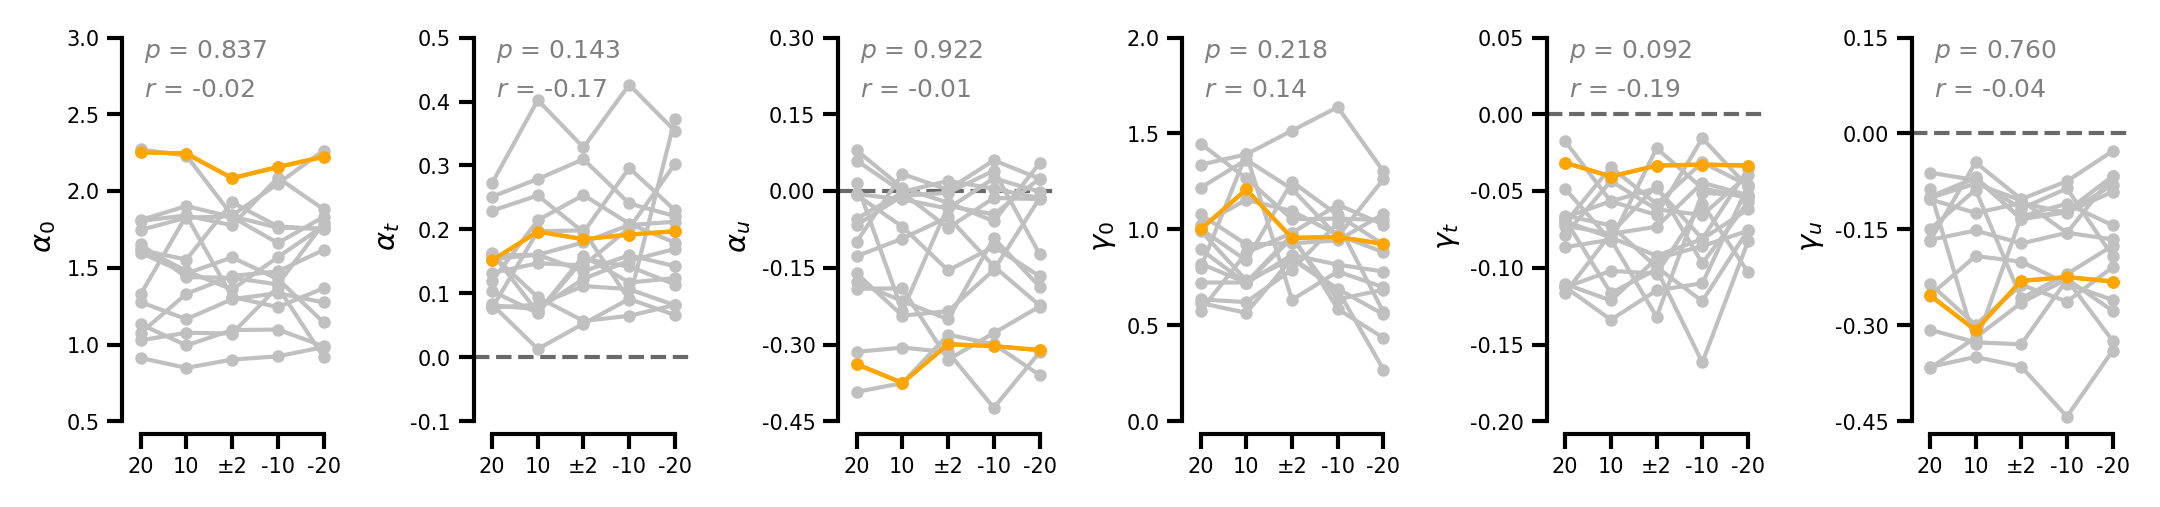

In [18]:
def Figure4L(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [alpha_0[animal]["20"], alpha_0[animal]["10"], alpha_0[animal]["2"], alpha_0[animal]["rev10"], alpha_0[animal]["rev20"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], label='Individuals')
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2, 3, 4], [alpha_0[animal]["20"], alpha_0[animal]["10"], alpha_0[animal]["2"], alpha_0[animal]["rev10"], alpha_0[animal]["rev20"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5, label='Example rat')

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{belt}$'
    if show_xlabel:
        ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(0.5, 3)
    ax.set_yticks([0.5, 1, 1.5, 2, 2.5, 3])
    ax.set_ylabel(r'$\alpha_0$')

    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_vbelt(alpha_0, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)
    r, p_value = regression_permutation(alpha_0, dist_or_tm='tm')
    annotate_regression(p_value, r, ax)

def Figure4M(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [alpha_t[animal]["20"], alpha_t[animal]["10"], alpha_t[animal]["2"], alpha_t[animal]["rev10"], alpha_t[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatM00':
            ax.plot([0, 1, 2, 3, 4], [alpha_t[animal]["20"], alpha_t[animal]["10"], alpha_t[animal]["2"], alpha_t[animal]["rev10"], alpha_t[animal]["rev20"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{belt}$'
    if show_xlabel:
        ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-0.1, .5)
    ax.set_yticks([-0.1, 0, .1, .2, .3, .4, .5])
    ax.set_ylabel(r'$\alpha_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)

    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_vbelt(alpha_t, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)
    r, p_value = regression_permutation(alpha_t, dist_or_tm='tm')
    annotate_regression(p_value, r, ax)

def Figure4N(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [alpha_u[animal]["20"], alpha_u[animal]["10"], alpha_u[animal]["2"], alpha_u[animal]["rev10"], alpha_u[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2, 3, 4], [alpha_u[animal]["20"], alpha_u[animal]["10"], alpha_u[animal]["2"], alpha_u[animal]["rev10"], alpha_u[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{belt}$'
    if show_xlabel:
        ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-0.45, .30)
    ax.set_yticks([-0.45, -.30, -.15, 0, 0.15, .30])
    # ax.set_yticklabels(["-0.5", -.25, "0.0", .25, "0.5"])
    ax.set_ylabel(r'$\alpha_u$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_vbelt(alpha_u, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)
    r, p_value = regression_permutation(alpha_u, dist_or_tm='tm')
    annotate_regression(p_value, r, ax)



def Figure4O(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [gamma_0[animal]["20"], gamma_0[animal]["10"], gamma_0[animal]["2"], gamma_0[animal]["rev10"], gamma_0[animal]["rev20"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], label='Individuals')
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2, 3, 4], [gamma_0[animal]["20"], gamma_0[animal]["10"], gamma_0[animal]["2"], gamma_0[animal]["rev10"], gamma_0[animal]["rev20"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5, label='Example rat')

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{belt}$'
    if show_xlabel:
        ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(0, 2)
    ax.set_yticks([0, 0.5, 1, 1.5, 2])
    ax.set_ylabel(r'$\gamma_0$')
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_vbelt(gamma_0, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)
    r, p_value = regression_permutation(gamma_0, dist_or_tm='tm')
    annotate_regression(p_value, r, ax)

def Figure4P(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [gamma_t[animal]["20"], gamma_t[animal]["10"], gamma_t[animal]["2"], gamma_t[animal]["rev10"], gamma_t[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatM00':
            ax.plot([0, 1, 2, 3, 4], [gamma_t[animal]["20"], gamma_t[animal]["10"], gamma_t[animal]["2"], gamma_t[animal]["rev10"], gamma_t[animal]["rev20"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{belt}$'
    if show_xlabel:
        ax.set_xlabel(f'{_} (cm/s)')


    # plotmedian(gamma_t, ax=ax, dist_or_tm='tm')

    ax.set_ylim(-0.2, 0.05)
    ax.set_yticks([-0.2, -.15, -.1, -.05, 0, 0.05])
    ax.set_ylabel(r'$\gamma_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_vbelt(gamma_t, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, shifty=0.05, num_permutations=10000)
    r, p_value = regression_permutation(gamma_t, dist_or_tm='tm')
    annotate_regression(p_value, r, ax)

def Figure4Q(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [gamma_u[animal]["20"], gamma_u[animal]["10"], gamma_u[animal]["2"], gamma_u[animal]["rev10"], gamma_u[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2, 3, 4], [gamma_u[animal]["20"], gamma_u[animal]["10"], gamma_u[animal]["2"], gamma_u[animal]["rev10"], gamma_u[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{belt}$'
    if show_xlabel:
        ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-0.45, 0.15)
    ax.set_yticks([-.45, -.3, -.15, 0, .15])
    ax.set_ylabel(r'$\gamma_u$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_vbelt(gamma_u, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, shifty=0.05, num_permutations=10000)
    r, p_value = regression_permutation(gamma_u, dist_or_tm='tm')
    annotate_regression(p_value, r, ax)

fig, axs = plt.subplots(1, 6, figsize=(cm2inch(18), cm2inch(4)))
Figure4L(axs[0])
Figure4M(axs[1])
Figure4N(axs[2])
Figure4O(axs[3])
Figure4P(axs[4])
Figure4Q(axs[5])

# illustrations

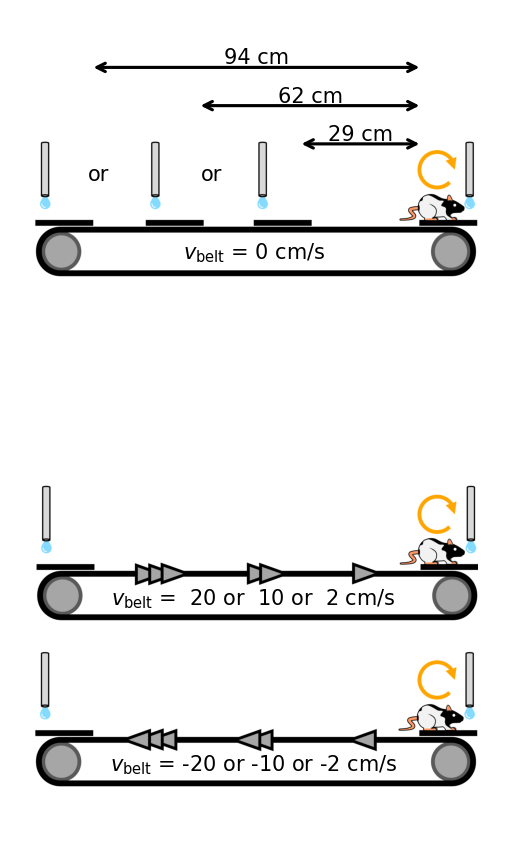

In [19]:
def Figure2E(ax=None, path=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    if path is None:
        path = "/home/david/Desktop/code/Figures/2Didle.png"

    img = plt.imread(path)
    img = img[300:2000, 150:3075]
    ax.imshow(img)
    ax.axis("off")
    ax.text(s=r'$v_{\mathrm{belt}}$ = 0 cm/s', x=img.shape[1]/2, y=1460, ha="center", va="center", fontsize=5)
    ax.text(s='or', x=450, y=950, ha="center", va="center", fontsize=5)
    ax.text(s='or', x=1185, y=950, ha="center", va="center", fontsize=5)

    ax.annotate(text='', xy=(1720, 750), xytext=(2600, 750), arrowprops=dict(arrowstyle='<->', lw=0.75), fontsize=5, zorder=5)
    ax.annotate(text='', xy=(1060, 500), xytext=(2600, 500), arrowprops=dict(arrowstyle='<->', lw=0.75), fontsize=5, zorder=5)
    ax.annotate(text='', xy=(360, 250), xytext=(2600, 250), arrowprops=dict(arrowstyle='<->', lw=0.75), fontsize=5, zorder=5)
    
    ax.annotate(text='29 cm', xy=(0, 0), xytext=((1720+2600)/2, 750), ha='center', va='bottom', xycoords='data', fontsize=5, zorder=5)
    ax.annotate(text='62 cm', xy=(0, 0), xytext=((1060+2600)/2, 500), ha='center', va='bottom', xycoords='data', fontsize=5, zorder=5)
    ax.annotate(text='94 cm', xy=(0, 0), xytext=((360+2600)/2, 250), ha='center', va='bottom', xycoords='data', fontsize=5, zorder=5)

def Figure2J(ax=None, path=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    if path is None:
        path = "/home/david/Desktop/code/Figures/2Eidle.png"

    img = plt.imread(path)
    img = img[:, 150:3075]
    ax.imshow(img)
    ax.axis("off")
    ax.text(s=r'$v_{\mathrm{belt}}$ =  20 or  10 or  2 cm/s', x=img.shape[1]/2, y=930, ha="center", va="center", fontsize=5)
    ax.text(s=r'$v_{\mathrm{belt}}$ = -20 or -10 or -2 cm/s', x=img.shape[1]/2, y=2020, ha="center", va="center", fontsize=5)

fig, axs = plt.subplots(2, 1, figsize=(cm2inch(4), cm2inch(8)))
Figure2E(ax=axs[0])
Figure2J(ax=axs[1])

# Figure 4

In [20]:

# fig = plt.figure(figsize=(cm2inch(8.8), cm2inch(12)), 
#                  constrained_layout=True, facecolor='w', dpi=600)

# gs0 = fig.add_gridspec(7, 3, height_ratios=[1, .1, 1, .1, 1, .1, 1], width_ratios=[1, 1, 1])

# drift_diffusion_base = plt.subplot(gs0[0, 0])
# drift_diffusion_1 = plt.subplot(gs0[0, 1])
# drift_diffusion_2 = plt.subplot(gs0[0, 2])

# explanation_alpha_0 = plt.subplot(gs0[2, 0])
# explanation_alpha_t = plt.subplot(gs0[2, 1])
# explanation_alpha_u = plt.subplot(gs0[2, 2])
# explanation_gamma_0 = plt.subplot(gs0[4, 0])
# explanation_gamma_t = plt.subplot(gs0[4, 1])
# explanation_gamma_u = plt.subplot(gs0[4, 2])

# fit_early = plt.subplot(gs0[6, 0])
# fit_late = plt.subplot(gs0[6, 1])
# modeldata = plt.subplot(gs0[6, 2])


# x, y = Figure4_A(ax=drift_diffusion_base, A=8, mean=.2, base=True, 
#                  alphacolor=plt.get_cmap('cool_r')(0.1), gammacolor=plt.get_cmap('autumn')(0.1))
# Figure4_A(ax=drift_diffusion_1, A=14, mean=.2, base=False, 
#           alphacolor=plt.get_cmap('cool_r')(0.9), gammacolor=plt.get_cmap('autumn')(0.1), xx=x, yy=y)
# Figure4_A(ax=drift_diffusion_2, A=8, mean=.1, base=False, 
#           alphacolor=plt.get_cmap('cool_r')(0.1), gammacolor=plt.get_cmap('autumn')(0.8), xx=x, yy=y)
# # Figure4_A(ax=drift_diffusion_3, A=14, mean=.1, base=False, alphacolor=plt.get_cmap('cool_r')(0.9), gammacolor=plt.get_cmap('autumn')(0.8))


# Figure4A(ax=explanation_alpha_0, cmap=plt.get_cmap("cool_r"), hide_xlabel=True)
# Figure4B(ax=explanation_alpha_t, cmap=plt.get_cmap("cool_r"), hide_xlabel=True)
# Figure4C(ax=explanation_alpha_u, cmap=plt.get_cmap("cool_r"), hide_xlabel=True)
# Figure4A(ax=explanation_gamma_0)
# Figure4B(ax=explanation_gamma_t, reverse=True)
# Figure4C(ax=explanation_gamma_u, reverse=True)

# plot_distribution_idle(fit_early, timebin=0, historybin=0)
# plot_distribution_idle(fit_late, timebin=5, historybin=0)
# Figure4D(ax=modeldata)


# figuresLabels={"A":[0.01, .98], "B":[0.01, .73], "C":[0.01, .49],  "D":[0.01, .23],}
# for label,coordinates in sorted(figuresLabels.items()):
#     fig.text(coordinates[0], coordinates[1],
#              label, figure=fig, 
#              weight='bold', fontsize=7, ha='left', va='bottom')

# # legend D manual because layout
# handles, labels = fit_early.get_legend_handles_labels()
# unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
# fig.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.23, 0.2), handletextpad=0.25,
#                 frameon=True, fontsize=5, markerscale=1, handlelength=.75, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

# handles, labels = fit_late.get_legend_handles_labels()
# unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
# fig.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.565, 0.2), handletextpad=0.25,
#                 frameon=True, fontsize=5, markerscale=1, handlelength=.75, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


# # colorbars
# fig.canvas.draw()
# bounds = [_ax.get_position().bounds for _ax in fig.axes]
# fig.set_constrained_layout(False)

# plot_colorbar(ax_input=explanation_alpha_0, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\alpha_0$', y_label=1.5, labelpad=-15, 
#               cmap='cool_r', labels=[1.5, 0, 8.25])

# plot_colorbar(ax_input=explanation_alpha_t, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\alpha_t$', y_label=1.5, labelpad=-12, 
#               cmap='cool_r', labels=[0, 0, 1.5])

# plot_colorbar(ax_input=explanation_alpha_u, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\alpha_u$', y_label=1.5, labelpad=-10, 
#               show_zero=160, cmap='cool_r', labels=[-1, 0, 12])

# plot_colorbar(ax_input=explanation_gamma_0, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\gamma_0$', y_label=1.5, labelpad=-15, 
#               cmap='autumn_r', labels=[1.5, 0, 8.25])

# plot_colorbar(ax_input=explanation_gamma_t, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\gamma_t$', y_label=1.5, labelpad=-14, 
#               cmap='autumn_r', labels=[0, 0, -1.5])

# plot_colorbar(ax_input=explanation_gamma_u, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\gamma_u$', y_label=1.5, labelpad=-12, 
#               show_zero=160, cmap='autumn_r', labels=[1, 0, -12])

# for i, ax in enumerate(axs.flat):
#     ax.set_position(bounds[i])
# fig.canvas.draw()


# fig.text(s=r'$\alpha(t, R) = \alpha_0 + \alpha_t t + \alpha_u R$', x=0.5, y=.725, ha="center", va="bottom", fontsize=7)
# fig.text(s=r'$\gamma(t, R) = \gamma_0 + \gamma_t t + \gamma_u R$', x=0.5, y=.49, ha="center", va="bottom", fontsize=7)

# plt.savefig("/home/david/Desktop/code/Figure_4_1_.pdf", facecolor='w', 
#         edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

In [21]:

# fig = plt.figure(figsize=(cm2inch(18), cm2inch(9)), 
#                  constrained_layout=True, facecolor='w', dpi=600)

# gs0 = fig.add_gridspec(4, 5, height_ratios=[1, .1, 1, 1], width_ratios=[1, 1, 1, 1, 1])

# drift_diffusion_base = plt.subplot(gs0[0, 0])
# drift_diffusion_1 = plt.subplot(gs0[0, 1])
# drift_diffusion_2 = plt.subplot(gs0[0, 2])

# explanation_alpha_0 = plt.subplot(gs0[2, 0])
# explanation_alpha_t = plt.subplot(gs0[2, 1])
# explanation_alpha_u = plt.subplot(gs0[2, 2])
# explanation_gamma_0 = plt.subplot(gs0[3, 0])
# explanation_gamma_t = plt.subplot(gs0[3, 1])
# explanation_gamma_u = plt.subplot(gs0[3, 2])

# fit_early = plt.subplot(gs0[0, 3])
# fit_late = plt.subplot(gs0[0, 4])

# gs1 = gs0[2:, 3:].subgridspec(1, 1)
# # gs1 = gs0[2:, 3:].subgridspec(3, 3, height_ratios=[1, 5, 1], width_ratios=[1, 5, 1])
# # modeldata = plt.subplot(gs1[1, 1])
# modeldata = plt.subplot(gs1[0, 0])


# x, y = Figure4_A(ax=drift_diffusion_base, A=8, mean=.2, base=True, 
#                  alphacolor=plt.get_cmap('cool_r')(0.1), gammacolor=plt.get_cmap('autumn')(0.1))
# Figure4_A(ax=drift_diffusion_1, A=14, mean=.2, base=False, 
#           alphacolor=plt.get_cmap('cool_r')(0.9), gammacolor=plt.get_cmap('autumn')(0.1), xx=x, yy=y)
# Figure4_A(ax=drift_diffusion_2, A=8, mean=.1, base=False, 
#           alphacolor=plt.get_cmap('cool_r')(0.1), gammacolor=plt.get_cmap('autumn')(0.8), xx=x, yy=y)
# # Figure4_A(ax=drift_diffusion_3, A=14, mean=.1, base=False, alphacolor=plt.get_cmap('cool_r')(0.9), gammacolor=plt.get_cmap('autumn')(0.8))


# Figure4A(ax=explanation_alpha_0, cmap=plt.get_cmap("cool_r"), hide_xlabel=True)
# Figure4B(ax=explanation_alpha_t, cmap=plt.get_cmap("cool_r"), hide_xlabel=True, hide_ylabel=True)
# Figure4C(ax=explanation_alpha_u, cmap=plt.get_cmap("cool_r"), hide_xlabel=True, hide_ylabel=True)
# Figure4A(ax=explanation_gamma_0)
# Figure4B(ax=explanation_gamma_t, reverse=True, hide_ylabel=True)
# Figure4C(ax=explanation_gamma_u, reverse=True, hide_ylabel=True)

# plot_distribution_idle(fit_early, timebin=0, historybin=0)
# plot_distribution_idle(fit_late, timebin=5, historybin=0)
# Figure4D(ax=modeldata)


# figuresLabels={"A":[0.01, .98], "B":[0.01, .73], "C":[0.01, .49],  "D":[0.01, .23],}
# for label,coordinates in sorted(figuresLabels.items()):
#     fig.text(coordinates[0], coordinates[1],
#              label, figure=fig, 
#              weight='bold', fontsize=7, ha='left', va='bottom')

# # legend D manual because layout
# # handles, labels = fit_early.get_legend_handles_labels()
# # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
# # fig.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.23, 0.2), handletextpad=0.25,
# #                 frameon=True, fontsize=5, markerscale=1, handlelength=.75, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

# # handles, labels = fit_late.get_legend_handles_labels()
# # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
# # fig.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.565, 0.2), handletextpad=0.25,
# #                 frameon=True, fontsize=5, markerscale=1, handlelength=.75, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


# # colorbars
# fig.canvas.draw()
# bounds = [_ax.get_position().bounds for _ax in fig.axes]
# fig.set_constrained_layout(False)

# plot_colorbar(ax_input=explanation_alpha_0, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\alpha_0$', y_label=1.5, labelpad=-15, 
#               cmap='cool_r', labels=[1.5, 0, 8.25])

# plot_colorbar(ax_input=explanation_alpha_t, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\alpha_t$', y_label=1.5, labelpad=-12, 
#               cmap='cool_r', labels=[0, 0, 1.5])

# plot_colorbar(ax_input=explanation_alpha_u, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\alpha_u$', y_label=1.5, labelpad=-10, 
#               show_zero=160, cmap='cool_r', labels=[-1, 0, 12])

# plot_colorbar(ax_input=explanation_gamma_0, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\gamma_0$', y_label=1.5, labelpad=-15, 
#               cmap='autumn_r', labels=[1.5, 0, 8.25])

# plot_colorbar(ax_input=explanation_gamma_t, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\gamma_t$', y_label=1.5, labelpad=-14, 
#               cmap='autumn_r', labels=[0, 0, -1.5])

# plot_colorbar(ax_input=explanation_gamma_u, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\gamma_u$', y_label=1.5, labelpad=-12, 
#               show_zero=160, cmap='autumn_r', labels=[1, 0, -12])

# for i, ax in enumerate(axs.flat):
#     ax.set_position(bounds[i])
# fig.canvas.draw()


# # fig.text(s=r'$\alpha(t, R) = \alpha_0 + \alpha_t t + \alpha_u R$', x=0.5, y=.63, ha="center", va="bottom", fontsize=7)
# # fig.text(s=r'$\gamma(t, R) = \gamma_0 + \gamma_t t + \gamma_u R$', x=0.5, y=.32, ha="center", va="bottom", fontsize=7)

# def color_axes(fig, color='red'):
#     for ax in fig.get_axes():
#         color = np.random.rand(3)
#         bbox = ax.get_position()
#         rect = plt.Rectangle((bbox.x0, bbox.y0), bbox.width, bbox.height, 
#                              fill=False, transform=fig.transFigure, edgecolor='r', linewidth=2.5)
#         fig.patches.append(rect)

# color_axes(plt.gcf())
# # plt.savefig("/home/david/Desktop/code/Figure_4_1_.pdf", facecolor='w', 
# #         edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

/home/david/Desktop/code/VIGOR_MODELS_Functions.py:590: RuntimeWarning: divide by zero encountered in true_divide
  res = alpha / np.sqrt(arg) * np.exp(-((alpha-gamma * x) ** 2) / (2 * x))
/home/david/Desktop/code/VIGOR_MODELS_Functions.py:590: RuntimeWarning: invalid value encountered in multiply
  res = alpha / np.sqrt(arg) * np.exp(-((alpha-gamma * x) ** 2) / (2 * x))


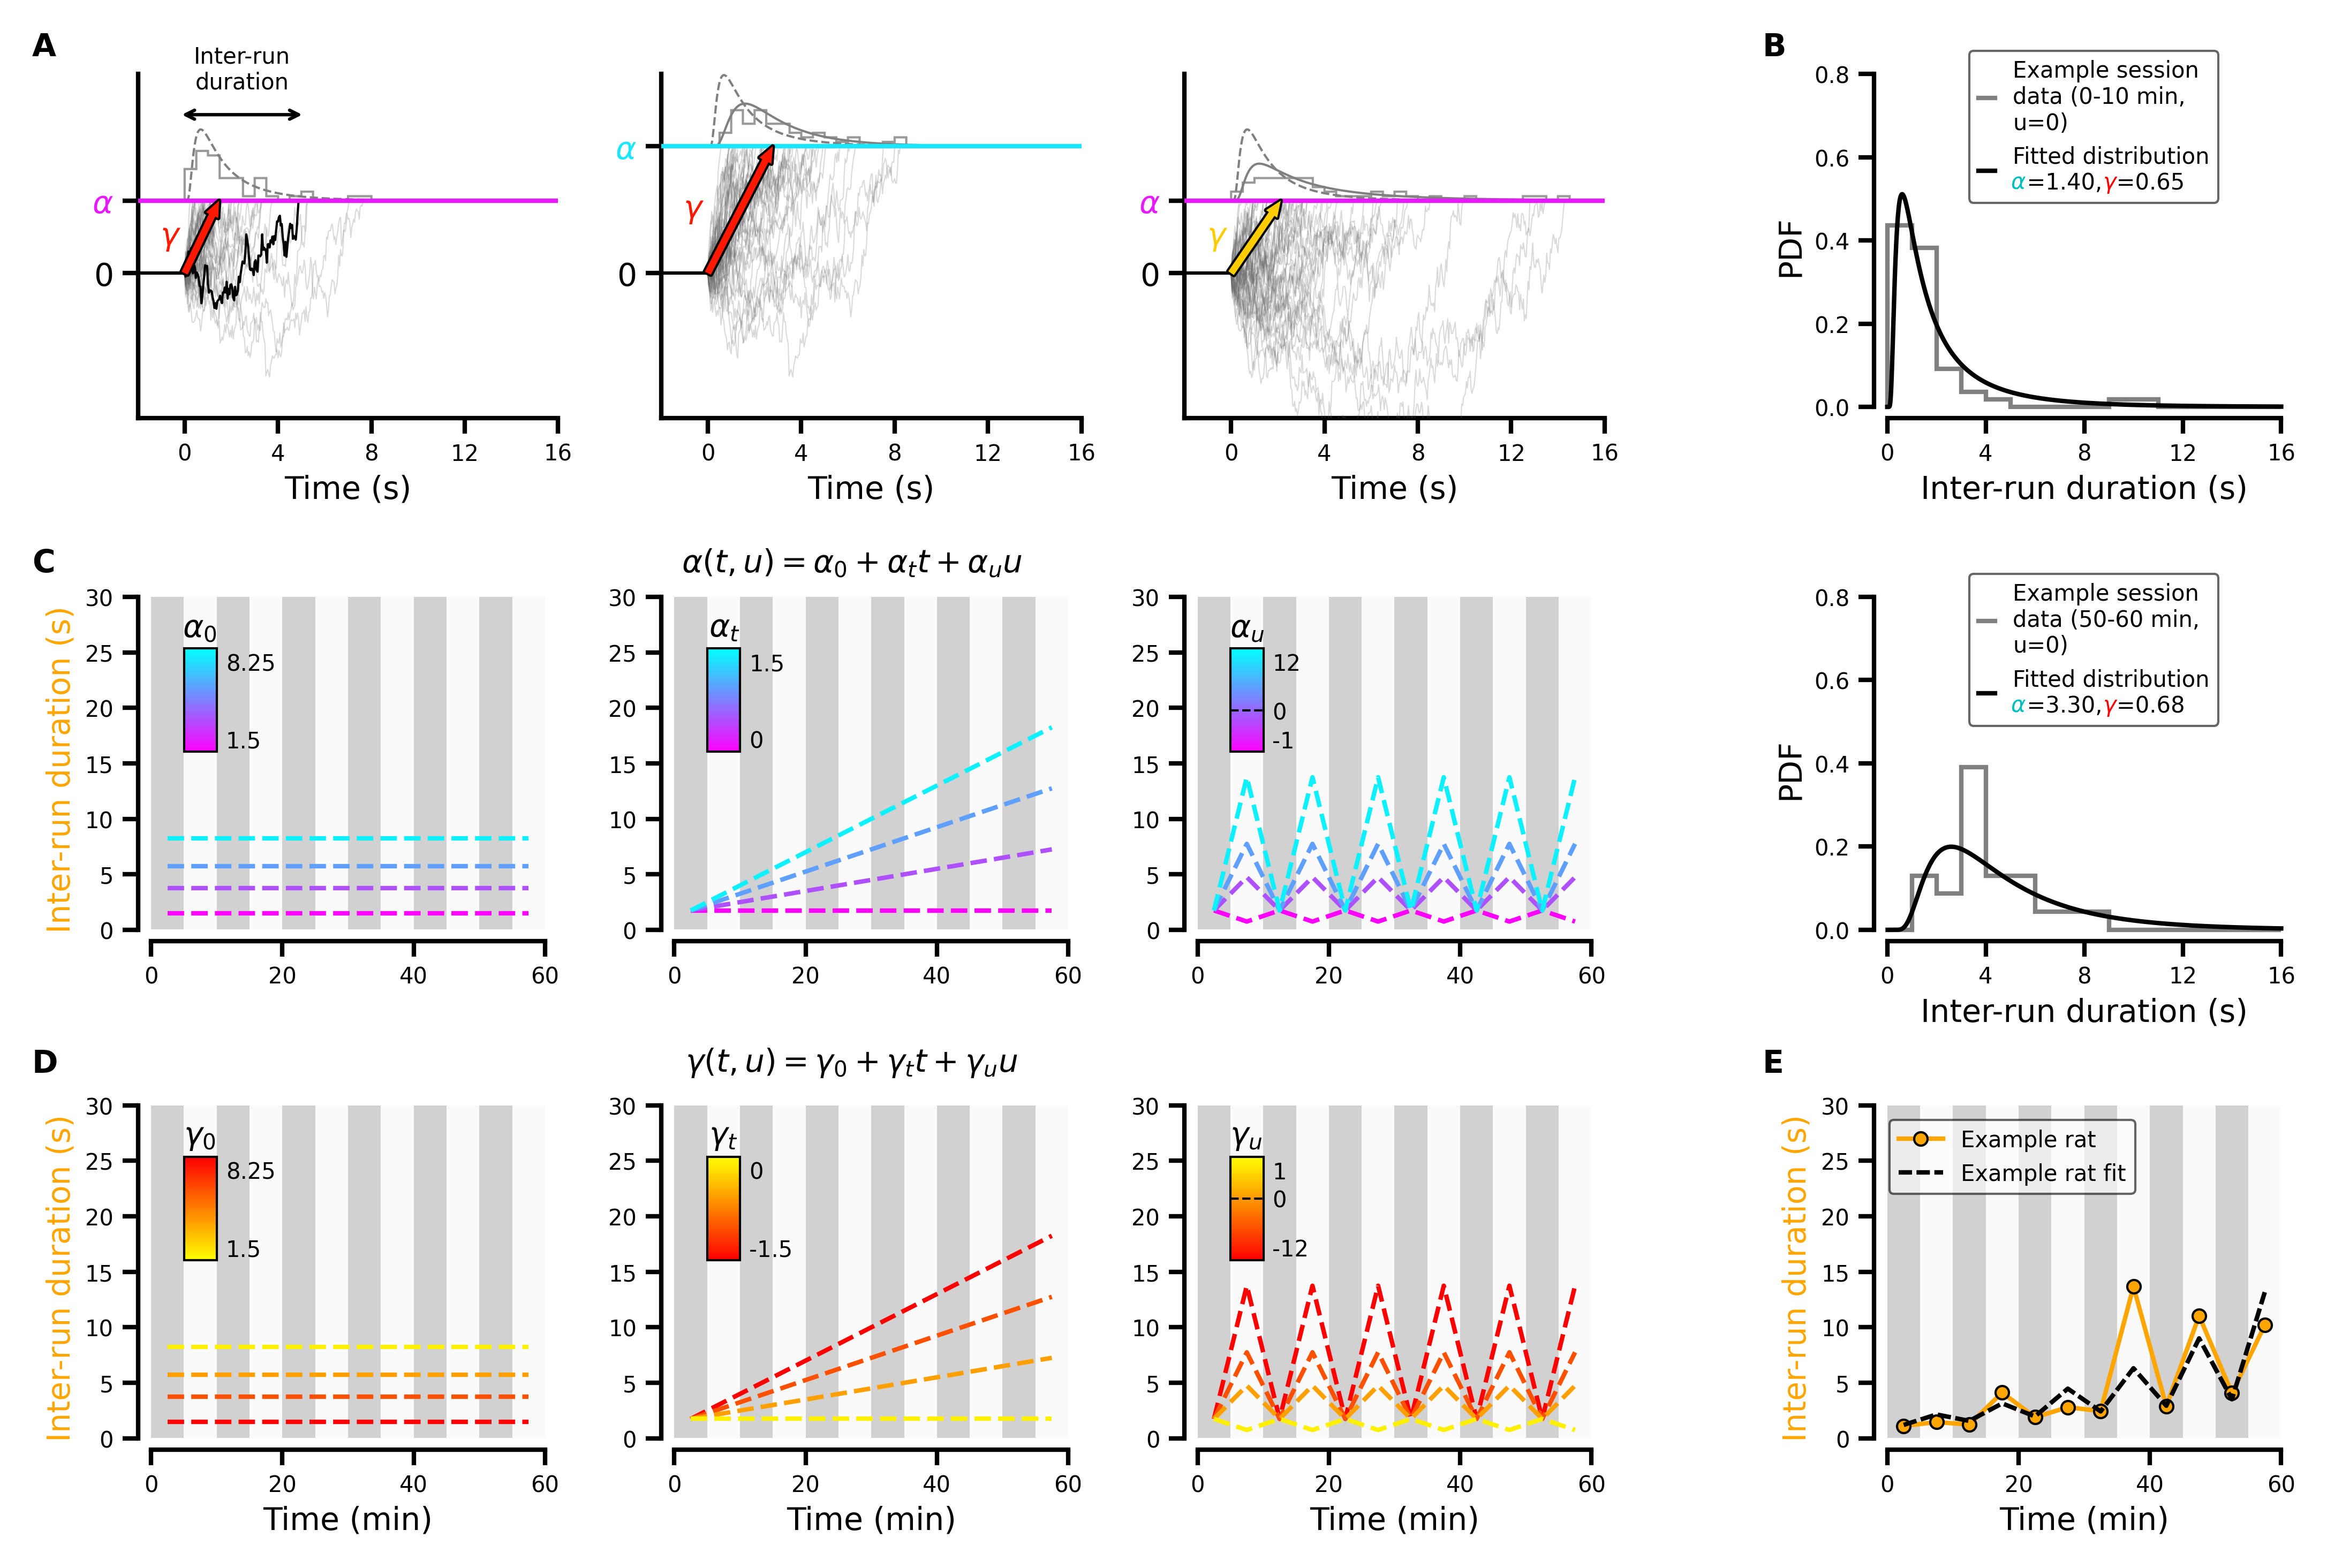

In [22]:

fig = plt.figure(figsize=(cm2inch(18), cm2inch(12)), 
                 constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(5, 5, height_ratios=[1, .01, 1, .01, 1], width_ratios=[1, 1, 1, .2, 1])

drift_diffusion_base = plt.subplot(gs0[0, 0])
drift_diffusion_1 = plt.subplot(gs0[0, 1])
drift_diffusion_2 = plt.subplot(gs0[0, 2])

explanation_alpha_0 = plt.subplot(gs0[2, 0])
explanation_alpha_t = plt.subplot(gs0[2, 1])
explanation_alpha_u = plt.subplot(gs0[2, 2])
explanation_gamma_0 = plt.subplot(gs0[4, 0])
explanation_gamma_t = plt.subplot(gs0[4, 1])
explanation_gamma_u = plt.subplot(gs0[4, 2])

fit_early = plt.subplot(gs0[0, 4])
fit_late = plt.subplot(gs0[2, 4])
modeldata = plt.subplot(gs0[4, 4])





# gs1 = gs0[2:, 3:].subgridspec(1, 1)
# # gs1 = gs0[2:, 3:].subgridspec(3, 3, height_ratios=[1, 5, 1], width_ratios=[1, 5, 1])
# # modeldata = plt.subplot(gs1[1, 1])
# modeldata = plt.subplot(gs1[0, 0])


x, y = Figure4_A(ax=drift_diffusion_base, A=8, mean=.2, base=True, 
                 alphacolor=plt.get_cmap('cool_r')(0.1), gammacolor=plt.get_cmap('autumn')(0.1))
Figure4_A(ax=drift_diffusion_1, A=14, mean=.2, base=False, 
          alphacolor=plt.get_cmap('cool_r')(0.9), gammacolor=plt.get_cmap('autumn')(0.1), xx=x, yy=y)
Figure4_A(ax=drift_diffusion_2, A=8, mean=.1, base=False, 
          alphacolor=plt.get_cmap('cool_r')(0.1), gammacolor=plt.get_cmap('autumn')(0.8), xx=x, yy=y)
# Figure4_A(ax=drift_diffusion_3, A=14, mean=.1, base=False, alphacolor=plt.get_cmap('cool_r')(0.9), gammacolor=plt.get_cmap('autumn')(0.8))


Figure4A(ax=explanation_alpha_0, cmap=plt.get_cmap("cool_r"), hide_xlabel=True)
Figure4B(ax=explanation_alpha_t, cmap=plt.get_cmap("cool_r"), hide_xlabel=True, hide_ylabel=True)
Figure4C(ax=explanation_alpha_u, cmap=plt.get_cmap("cool_r"), hide_xlabel=True, hide_ylabel=True)
Figure4A(ax=explanation_gamma_0)
Figure4B(ax=explanation_gamma_t, reverse=True, hide_ylabel=True)
Figure4C(ax=explanation_gamma_u, reverse=True, hide_ylabel=True)

plot_distribution_idle(fit_early, timebin=0, historybin=0)
plot_distribution_idle(fit_late, timebin=5, historybin=0)
Figure4D(ax=modeldata)


figuresLabels={"A":[0.0, .98], "B":[0.76, .98], "C":[0.0, .64],  
               "D":[0.0, .31], "E":[0.76, .31]}
for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1], label, figure=fig, 
             weight='bold', fontsize=7, ha='left', va='bottom')

# legend D manual because layout
# handles, labels = fit_early.get_legend_handles_labels()
# unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
# fig.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.8, 0.8), handletextpad=0.25,
#                 frameon=True, fontsize=5, markerscale=1, handlelength=.75, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

# handles, labels = fit_late.get_legend_handles_labels()
# unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
# fig.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.9, 0.8), handletextpad=0.25,
#                 frameon=True, fontsize=5, markerscale=1, handlelength=.75, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)
fig.text(s=r'$\alpha(t, u) = \alpha_0 + \alpha_t t + \alpha_u u$', x=.36, y=.64, ha="center", va="bottom", fontsize=7)
fig.text(s=r'$\gamma(t, u) = \gamma_0 + \gamma_t t + \gamma_u u$', x=.36, y=.31, ha="center", va="bottom", fontsize=7)


# colorbars
fig.canvas.draw()
bounds = [_ax.get_position().bounds for _ax in fig.axes]
fig.set_constrained_layout(False)

plot_colorbar(ax_input=explanation_alpha_0, x=.11, y=.55, width=.078, height=.3, 
              label=r'$\alpha_0$', y_label=1.35, labelpad=-17, 
              cmap='cool_r', labels=[1.5, 0, 8.25])

plot_colorbar(ax_input=explanation_alpha_t, x=.11, y=.55, width=.078, height=.3, 
              label=r'$\alpha_t$', y_label=1.35, labelpad=-13.5, 
              cmap='cool_r', labels=[0, 0, 1.5])

plot_colorbar(ax_input=explanation_alpha_u, x=.11, y=.55, width=.078, height=.3, 
              label=r'$\alpha_u$', y_label=1.35, labelpad=-12, 
              show_zero=160, cmap='cool_r', labels=[-1, 0, 12])

plot_colorbar(ax_input=explanation_gamma_0, x=.11, y=.55, width=.078, height=.3, 
              label=r'$\gamma_0$', y_label=1.35, labelpad=-17, 
              cmap='autumn_r', labels=[1.5, 0, 8.25])

plot_colorbar(ax_input=explanation_gamma_t, x=.11, y=.55, width=.078, height=.3, 
              label=r'$\gamma_t$', y_label=1.35, labelpad=-15.5, 
              cmap='autumn', labels=[-1.5, 0, 0])

plot_colorbar(ax_input=explanation_gamma_u, x=.11, y=.55, width=.078, height=.3, 
              label=r'$\gamma_u$', y_label=1.35, labelpad=-14, 
              show_zero=240, cmap='autumn', labels=[-12, 0, 1])

for i, ax in enumerate(axs.flat):
    ax.set_position(bounds[i])
fig.canvas.draw()

plt.savefig("/home/david/Desktop/code/figures_paper/Figure_2.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

plt.savefig("/home/david/Desktop/code/figures_paper/Figure_2.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

In [23]:

# fig = plt.figure(figsize=(cm2inch(18), cm2inch(9)), 
#                  constrained_layout=True, facecolor='w', dpi=600)

# gs0 = fig.add_gridspec(4, 5, height_ratios=[1, .01, 1, 1], width_ratios=[1, 1, 1, 1, 1])

# drift_diffusion_base = plt.subplot(gs0[0, 0])
# drift_diffusion_1 = plt.subplot(gs0[0, 1])
# drift_diffusion_2 = plt.subplot(gs0[0, 2])

# explanation_alpha_0 = plt.subplot(gs0[2, 0])
# explanation_alpha_t = plt.subplot(gs0[2, 1])
# explanation_alpha_u = plt.subplot(gs0[2, 2])
# explanation_gamma_0 = plt.subplot(gs0[3, 0])
# explanation_gamma_t = plt.subplot(gs0[3, 1])
# explanation_gamma_u = plt.subplot(gs0[3, 2])

# fit_early = plt.subplot(gs0[0, 3])
# fit_late = plt.subplot(gs0[0, 4])

# # gs1 = gs0[1:, 3:].subgridspec(1, 1)
# # gs1 = gs0[1:, 3:].subgridspec(3, 3, height_ratios=[1, 5, 1], width_ratios=[1, 5, 1])
# # modeldata = plt.subplot(gs1[1, 1])
# # modeldata = plt.subplot(gs1[0, 0])


# x, y = Figure4_A(ax=drift_diffusion_base, A=8, mean=.2, base=True, 
#                  alphacolor=plt.get_cmap('cool_r')(0.1), gammacolor=plt.get_cmap('autumn')(0.1))
# Figure4_A(ax=drift_diffusion_1, A=14, mean=.2, base=False, 
#           alphacolor=plt.get_cmap('cool_r')(0.9), gammacolor=plt.get_cmap('autumn')(0.1), xx=x, yy=y)
# Figure4_A(ax=drift_diffusion_2, A=8, mean=.1, base=False, 
#           alphacolor=plt.get_cmap('cool_r')(0.1), gammacolor=plt.get_cmap('autumn')(0.8), xx=x, yy=y)
# # Figure4_A(ax=drift_diffusion_3, A=14, mean=.1, base=False, alphacolor=plt.get_cmap('cool_r')(0.9), gammacolor=plt.get_cmap('autumn')(0.8))


# Figure4A(ax=explanation_alpha_0, cmap=plt.get_cmap("cool_r"), hide_xlabel=True)
# Figure4B(ax=explanation_alpha_t, cmap=plt.get_cmap("cool_r"), hide_xlabel=True, hide_ylabel=True)
# Figure4C(ax=explanation_alpha_u, cmap=plt.get_cmap("cool_r"), hide_xlabel=True, hide_ylabel=True)
# Figure4A(ax=explanation_gamma_0)
# Figure4B(ax=explanation_gamma_t, reverse=True, hide_ylabel=True)
# Figure4C(ax=explanation_gamma_u, reverse=True, hide_ylabel=True)

# plot_distribution_idle(fit_early, timebin=0, historybin=0)
# plot_distribution_idle(fit_late, timebin=5, historybin=0)
# # Figure4D(ax=modeldata)

# bboxx1 = fit_early.get_position()
# bboxx2 = fit_late.get_position()
# xx = (bboxx1.x0 + bboxx2.x1)/2

# bboxy1 = explanation_alpha_u.get_position()
# bboxy2 = explanation_gamma_u.get_position()
# yy = (bboxy1.y0 + bboxy2.y1)/2

# # modeldata = fig.add_axes([xx, yy, bboxx1.width, bboxx1.height])
# # # modeldata.set_position([xx, yy, bboxx1.width, bboxx1.height])
# # Figure4D(ax=modeldata)

# figuresLabels={"A":[0.01, .98], "B":[0.01, .73], "C":[0.01, .49],  "D":[0.01, .23],}
# for label,coordinates in sorted(figuresLabels.items()):
#     fig.text(coordinates[0], coordinates[1],
#              label, figure=fig, 
#              weight='bold', fontsize=7, ha='left', va='bottom')

# # legend D manual because layout
# # handles, labels = fit_early.get_legend_handles_labels()
# # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
# # fig.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.23, 0.2), handletextpad=0.25,
# #                 frameon=True, fontsize=5, markerscale=1, handlelength=.75, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

# # handles, labels = fit_late.get_legend_handles_labels()
# # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
# # fig.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.565, 0.2), handletextpad=0.25,
# #                 frameon=True, fontsize=5, markerscale=1, handlelength=.75, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


# # colorbars
# fig.canvas.draw()
# bounds = [_ax.get_position().bounds for _ax in fig.axes]
# fig.set_constrained_layout(False)

# plot_colorbar(ax_input=explanation_alpha_0, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\alpha_0$', y_label=1.5, labelpad=-15, 
#               cmap='cool_r', labels=[1.5, 0, 8.25])

# plot_colorbar(ax_input=explanation_alpha_t, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\alpha_t$', y_label=1.5, labelpad=-12, 
#               cmap='cool_r', labels=[0, 0, 1.5])

# plot_colorbar(ax_input=explanation_alpha_u, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\alpha_u$', y_label=1.5, labelpad=-10, 
#               show_zero=160, cmap='cool_r', labels=[-1, 0, 12])

# plot_colorbar(ax_input=explanation_gamma_0, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\gamma_0$', y_label=1.5, labelpad=-15, 
#               cmap='autumn_r', labels=[1.5, 0, 8.25])

# plot_colorbar(ax_input=explanation_gamma_t, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\gamma_t$', y_label=1.5, labelpad=-14, 
#               cmap='autumn_r', labels=[0, 0, -1.5])

# plot_colorbar(ax_input=explanation_gamma_u, x=.11, y=.55, width=.078, height=.3, 
#               label=r'$\gamma_u$', y_label=1.5, labelpad=-12, 
#               show_zero=160, cmap='autumn_r', labels=[1, 0, -12])

# for i, ax in enumerate(axs.flat):
#     ax.set_position(bounds[i])
# fig.canvas.draw()


# # fig.text(s=r'$\alpha(t, R) = \alpha_0 + \alpha_t t + \alpha_u R$', x=0.5, y=.63, ha="center", va="bottom", fontsize=7)
# # fig.text(s=r'$\gamma(t, R) = \gamma_0 + \gamma_t t + \gamma_u R$', x=0.5, y=.32, ha="center", va="bottom", fontsize=7)

# def color_axes(fig, color='red'):
#     for ax in fig.get_axes():
#         color = np.random.rand(3)
#         bbox = ax.get_position()
#         # print size of axes relative to figure size
#         print(f"left: {bbox.x0}, bottom: {bbox.y0}, width: {bbox.width}, height: {bbox.height}")
#         rect = plt.Rectangle((bbox.x0, bbox.y0), bbox.width, bbox.height, 
#                              fill=False, transform=fig.transFigure, edgecolor='r', linewidth=2.5)
#         fig.patches.append(rect)

# color_axes(plt.gcf())
# # plt.savefig("/home/david/Desktop/code/Figure_4_1_.pdf", facecolor='w', 
# #         edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

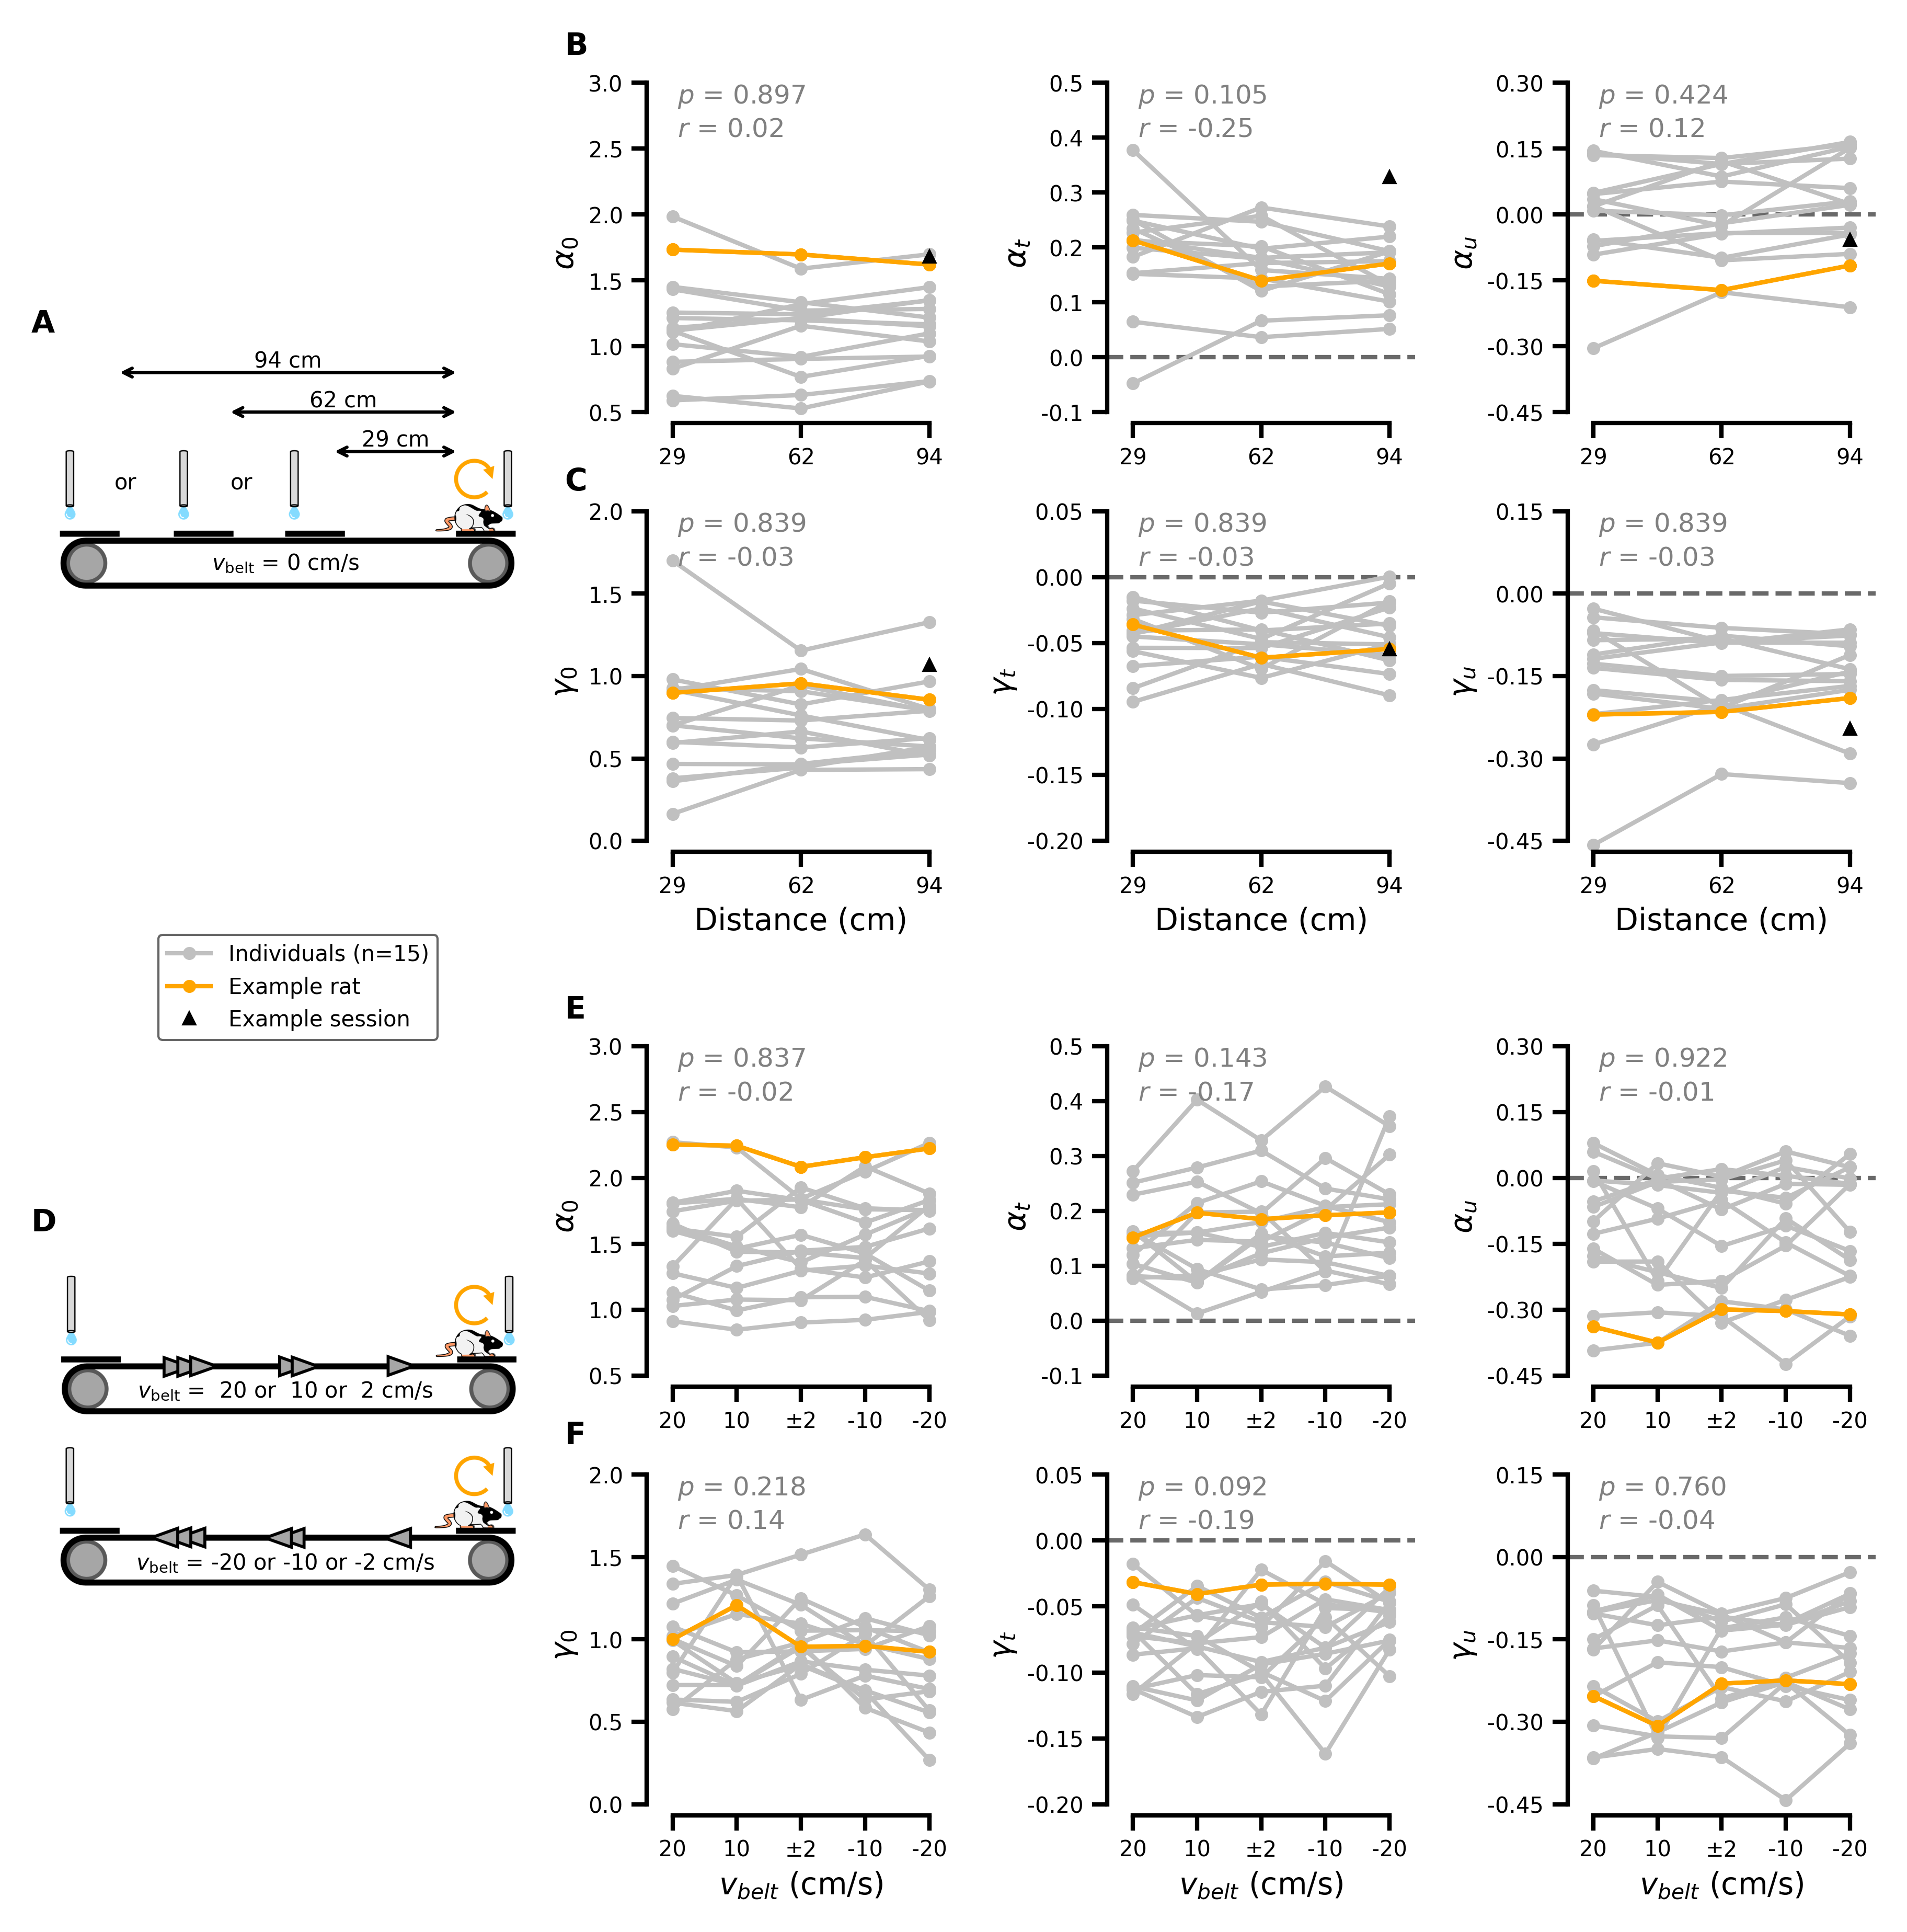

In [24]:

fig = plt.figure(figsize=(cm2inch(18), cm2inch(15)), 
                 constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(5, 6, width_ratios=[.5, 1.5, 1, 1, 1, .5], height_ratios=[1, 1, .1, 1, 1])

distance_schematic = plt.subplot(gs0[0:2, 1])
fit_alpha_0_distance = plt.subplot(gs0[0, 2])
fit_alpha_t_distance = plt.subplot(gs0[0, 3])
fit_alpha_u_distance = plt.subplot(gs0[0, 4])

fit_gamma_0_distance = plt.subplot(gs0[1, 2])
fit_gamma_t_distance = plt.subplot(gs0[1, 3])
fit_gamma_u_distance = plt.subplot(gs0[1, 4])


vbelt_schematic = plt.subplot(gs0[3:5, 1])
fit_alpha_0_vbelt = plt.subplot(gs0[3, 2])
fit_alpha_t_vbelt = plt.subplot(gs0[3, 3])
fit_alpha_u_vbelt = plt.subplot(gs0[3, 4])

fit_gamma_0_vbelt = plt.subplot(gs0[4, 2])
fit_gamma_t_vbelt = plt.subplot(gs0[4, 3])
fit_gamma_u_vbelt = plt.subplot(gs0[4, 4])

Figure2E(ax=distance_schematic)
Figure2J(ax=vbelt_schematic)

Figure4F(ax=fit_alpha_0_distance)
Figure4G(ax=fit_alpha_t_distance)
Figure4H(ax=fit_alpha_u_distance)
Figure4I(ax=fit_gamma_0_distance, show_xlabel=True)
Figure4J(ax=fit_gamma_t_distance, show_xlabel=True)
Figure4K(ax=fit_gamma_u_distance, show_xlabel=True)

Figure4L(ax=fit_alpha_0_vbelt)
Figure4M(ax=fit_alpha_t_vbelt)
Figure4N(ax=fit_alpha_u_vbelt)
Figure4O(ax=fit_gamma_0_vbelt, show_xlabel=True)
Figure4P(ax=fit_gamma_t_vbelt, show_xlabel=True)
Figure4Q(ax=fit_gamma_u_vbelt, show_xlabel=True)


figuresLabels={"A":[0.08, .85], "B":[0.32, 1], "C":[0.32, .765], 
                "D":[0.08, .365], "E":[0.32, .48], "F":[0.32, .25],
               }

for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1],
             label, figure=fig, 
             weight='bold', fontsize=7, ha='left', va='bottom')
    
handles, labels = fit_alpha_u_distance.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
fig.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.2, .5), 
                            frameon=True, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w', 
                            # title='Legend for all figures:     ', title_fontsize=5
                            ).get_frame().set_linewidth(.5)

plt.savefig("/home/david/Desktop/code/figures_paper/Figure_3.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)
plt.savefig("/home/david/Desktop/code/figures_paper/Figure_3.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

In [25]:
<<<<

SyntaxError: invalid syntax (1700047511.py, line 1)

/home/david/Desktop/code/VIGOR_MODELS_Functions.py:590: RuntimeWarning: divide by zero encountered in true_divide
  res = alpha / np.sqrt(arg) * np.exp(-((alpha-gamma * x) ** 2) / (2 * x))
/home/david/Desktop/code/VIGOR_MODELS_Functions.py:590: RuntimeWarning: invalid value encountered in multiply
  res = alpha / np.sqrt(arg) * np.exp(-((alpha-gamma * x) ** 2) / (2 * x))


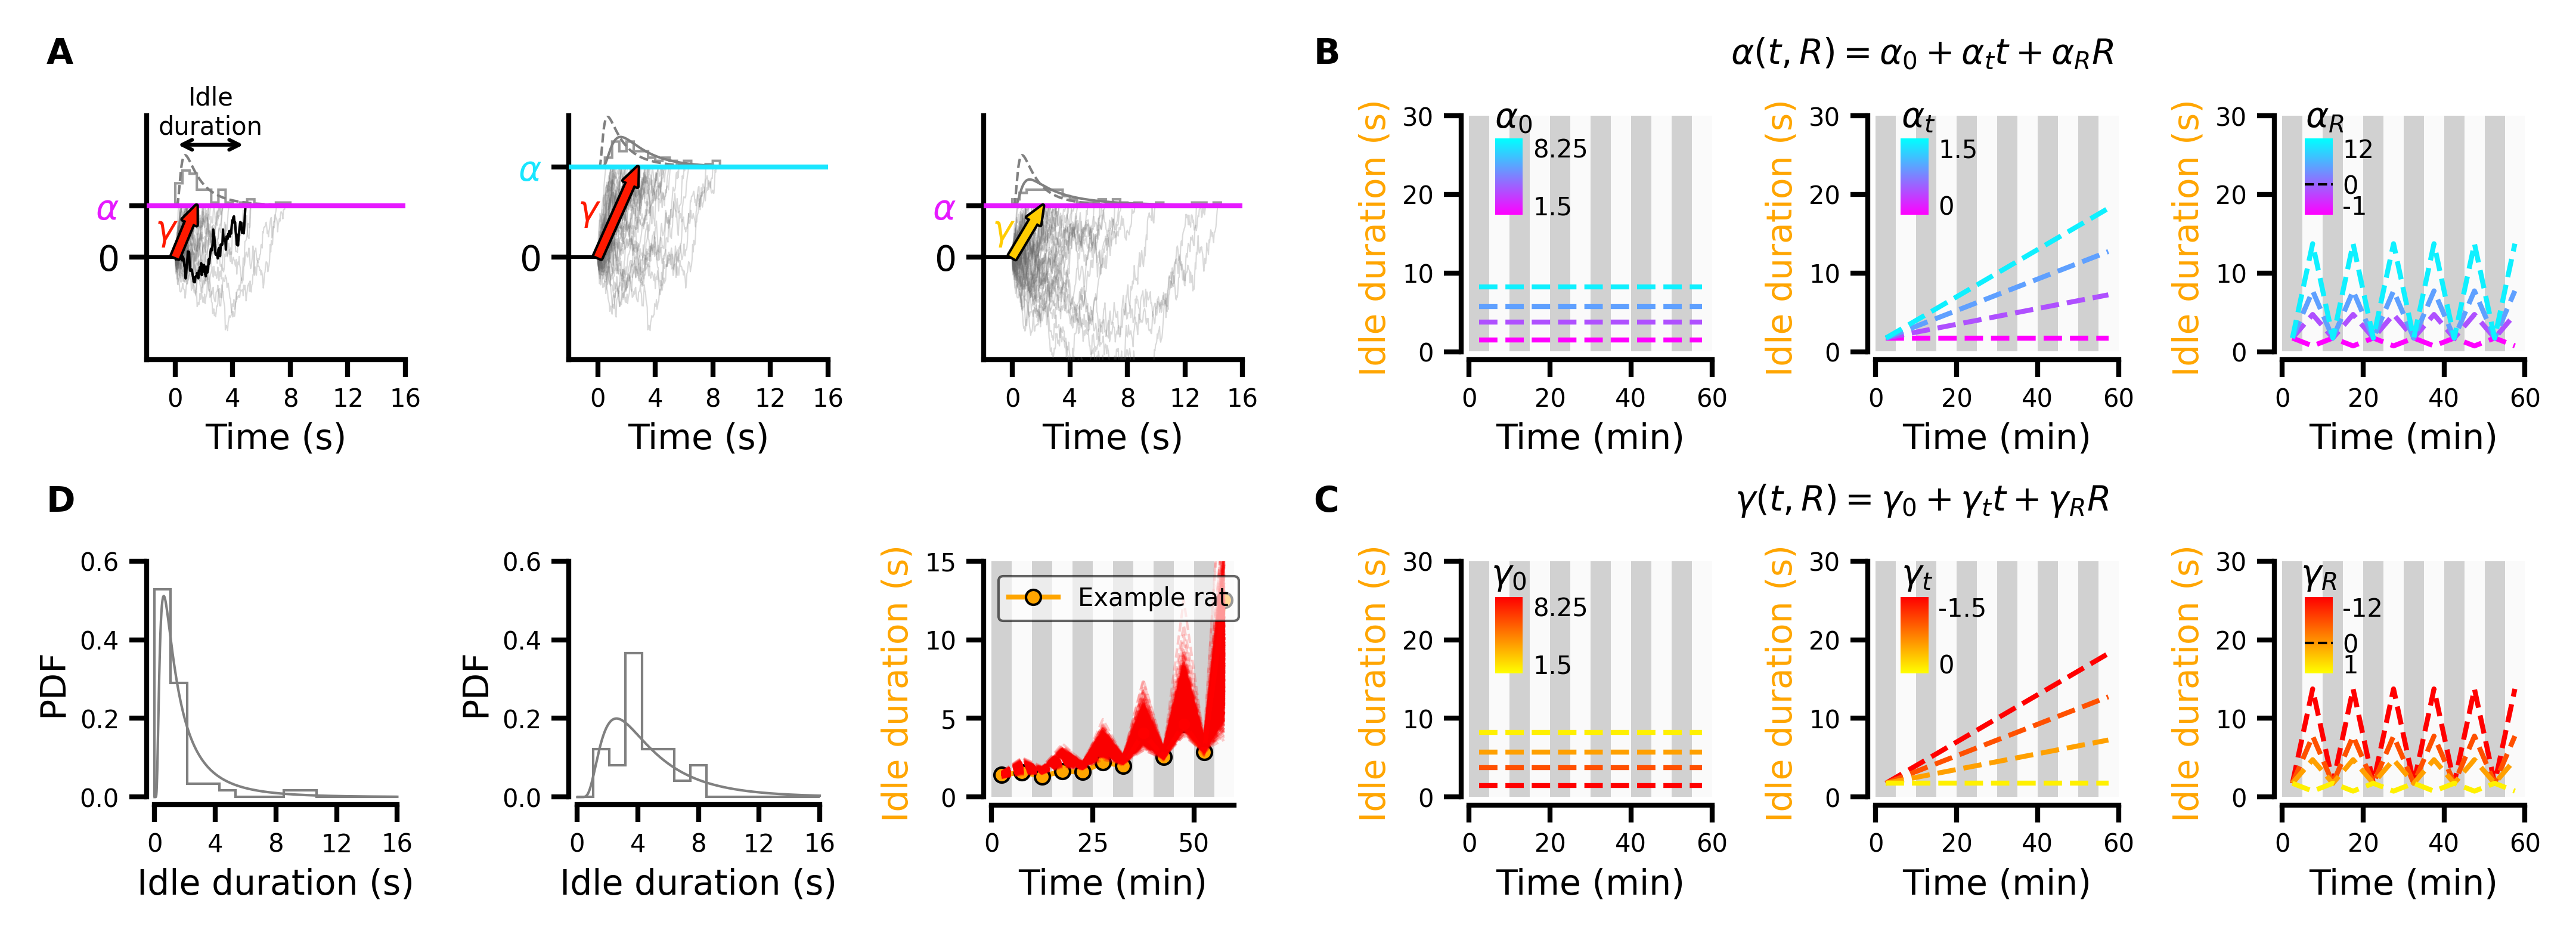

In [ ]:

fig = plt.figure(figsize=(cm2inch(18), cm2inch(6)), 
                 constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(3, 7, height_ratios=[1, .1, 1], width_ratios=[1, 1, 1, .1, 1, 1, 1])

drift_diffusion_base = plt.subplot(gs0[0, 0])
drift_diffusion_1 = plt.subplot(gs0[0, 1])
drift_diffusion_2 = plt.subplot(gs0[0, 2])

fit_early = plt.subplot(gs0[2, 0])
fit_late = plt.subplot(gs0[2, 1])
modeldata = plt.subplot(gs0[2, 2])

explanation_alpha_0 = plt.subplot(gs0[0, 4])
explanation_alpha_t = plt.subplot(gs0[0, 5])
explanation_alpha_u = plt.subplot(gs0[0, 6])
explanation_gamma_0 = plt.subplot(gs0[2, 4])
explanation_gamma_t = plt.subplot(gs0[2, 5])
explanation_gamma_u = plt.subplot(gs0[2, 6])




x, y = Figure4_A(ax=drift_diffusion_base, A=8, mean=.2, base=True, 
                 alphacolor=plt.get_cmap('cool_r')(0.1), gammacolor=plt.get_cmap('autumn')(0.1))
Figure4_A(ax=drift_diffusion_1, A=14, mean=.2, base=False, 
          alphacolor=plt.get_cmap('cool_r')(0.9), gammacolor=plt.get_cmap('autumn')(0.1), xx=x, yy=y)
Figure4_A(ax=drift_diffusion_2, A=8, mean=.1, base=False, 
          alphacolor=plt.get_cmap('cool_r')(0.1), gammacolor=plt.get_cmap('autumn')(0.8), xx=x, yy=y)
# Figure4_A(ax=drift_diffusion_3, A=14, mean=.1, base=False, alphacolor=plt.get_cmap('cool_r')(0.9), gammacolor=plt.get_cmap('autumn')(0.8))


Figure4A(ax=explanation_alpha_0, cmap=plt.get_cmap("cool_r"))
Figure4B(ax=explanation_alpha_t, cmap=plt.get_cmap("cool_r"))
Figure4C(ax=explanation_alpha_u, cmap=plt.get_cmap("cool_r"))
Figure4A(ax=explanation_gamma_0)
Figure4B(ax=explanation_gamma_t, reverse=True)
Figure4C(ax=explanation_gamma_u, reverse=True)

plot_distribution_idle(fit_early, timebin=0, historybin=0)
plot_distribution_idle(fit_late, timebin=-1, historybin=0)
Figure4D(ax=modeldata)


h, w = 0.09, 0.011

cbarA = fig.add_axes([.5815, .83, w, h])
plot_colorbar(ax=cbarA, label=r'$\alpha_0$', cmap="cool_r", labels=[1.5, 0, 8.25], y=1.5, labelpad=-15)

cbarB = fig.add_axes([.7415, .83, w, h])
plot_colorbar(ax=cbarB, label=r'$\alpha_t$', cmap="cool_r", labels=[0, 0, 1.5], y=1.5, labelpad=-12)

cbarC = fig.add_axes([.901, .83, w, h])
plot_colorbar(ax=cbarC, label=r'$\alpha_u$', show_zero=160, cmap="cool_r", labels=[-1, 0, 12], y=1.5, labelpad=-10)


cbarA = fig.add_axes([.5815, .2875, w, h])
plot_colorbar(ax=cbarA, label=r'$\gamma_0$', cmap="autumn_r", labels=[1.5, 0, 8.25], y=1.5, labelpad=-16)

cbarB = fig.add_axes([.7415, .2875, w, h])
plot_colorbar(ax=cbarB, label=r'$\gamma_t$', cmap="autumn_r", labels=[0, 0, -1.5], y=1.5, labelpad=-14)

cbarC = fig.add_axes([.901, .2875, w, h])
plot_colorbar(ax=cbarC, label=r'$\gamma_u$', cmap="autumn_r", show_zero=160, labels=[1, 0, -12], y=1.5, labelpad=-13)



figuresLabels={"A":[0.01, 1], "B":[0.51, 1], "D":[0.01, .47],  "C":[0.51, .47],}
for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1],
             label, figure=fig, 
             weight='bold', fontsize=7, ha='left', va='bottom')

plt.text(s=r'$\alpha(t, R) = \alpha_0 + \alpha_t t + \alpha_u R$', 
         x=0.75, y=1, ha="center", va="bottom", fontsize=7,
         transform=plt.gcf().transFigure)

plt.text(s=r'$\gamma(t, R) = \gamma_0 + \gamma_t t + \gamma_u R$', 
         x=0.75, y=.47, ha="center", va="bottom", fontsize=7,
         transform=plt.gcf().transFigure)

plt.savefig("/home/david/Desktop/code/Figure_4_1POSTER.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

# suppl

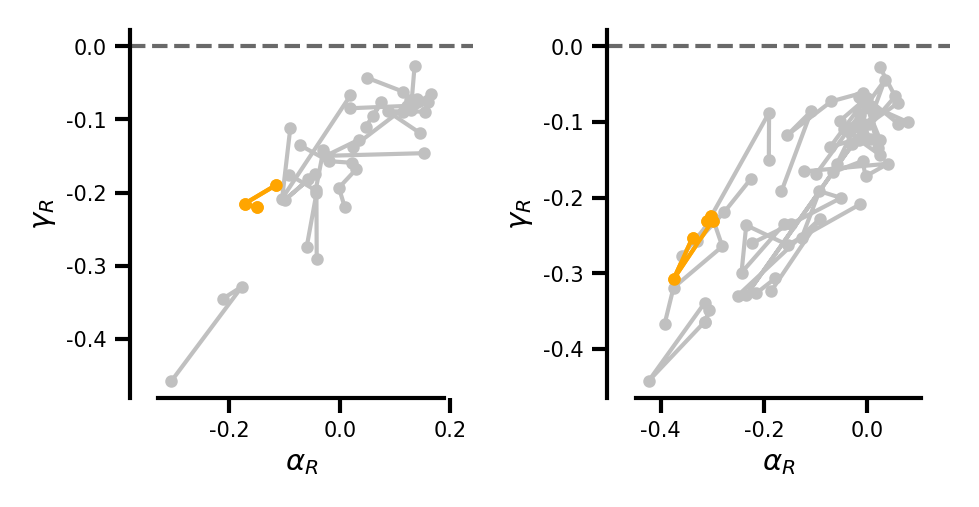

In [ ]:
def Figure4_(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([alpha_u[animal]["60"], alpha_u[animal]["90"], alpha_u[animal]["120"]], [gamma_u[animal]["60"], gamma_u[animal]["90"], gamma_u[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([alpha_u[animal]["60"], alpha_u[animal]["90"], alpha_u[animal]["120"]],
                     [gamma_u[animal]["60"], gamma_u[animal]["90"], gamma_u[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    # ax.set_xlim(0, 4)
    # ax.set_xticks([0, 1, 2, 3, 4])
    # ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])

    ax.set_xlabel(r'$\alpha_u$')

    # ax.set_ylim(-0.5, 0.1)
    ax.set_ylabel(r'$\gamma_u$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)

def Figure4__(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([alpha_u[animal]["rev20"], alpha_u[animal]["rev10"], alpha_u[animal]["2"], alpha_u[animal]["10"], alpha_u[animal]["20"]], [gamma_u[animal]["rev20"], gamma_u[animal]["rev10"], gamma_u[animal]["2"], gamma_u[animal]["10"], gamma_u[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([alpha_u[animal]["rev20"], alpha_u[animal]["rev10"], alpha_u[animal]["2"], alpha_u[animal]["10"], alpha_u[animal]["20"]],
                     [gamma_u[animal]["rev20"], gamma_u[animal]["rev10"], gamma_u[animal]["2"], gamma_u[animal]["10"], gamma_u[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    # ax.set_xlim(0, 4)
    # ax.set_xticks([0, 1, 2, 3, 4])
    # ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])

    ax.set_xlabel(r'$\alpha_u$')

    # ax.set_ylim(-0.5, 0.1)
    ax.set_ylabel(r'$\gamma_u$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)


fig, axs = plt.subplots(1, 2, figsize=(cm2inch(8), cm2inch(4)))
Figure4_(axs[0])
Figure4__(axs[1])

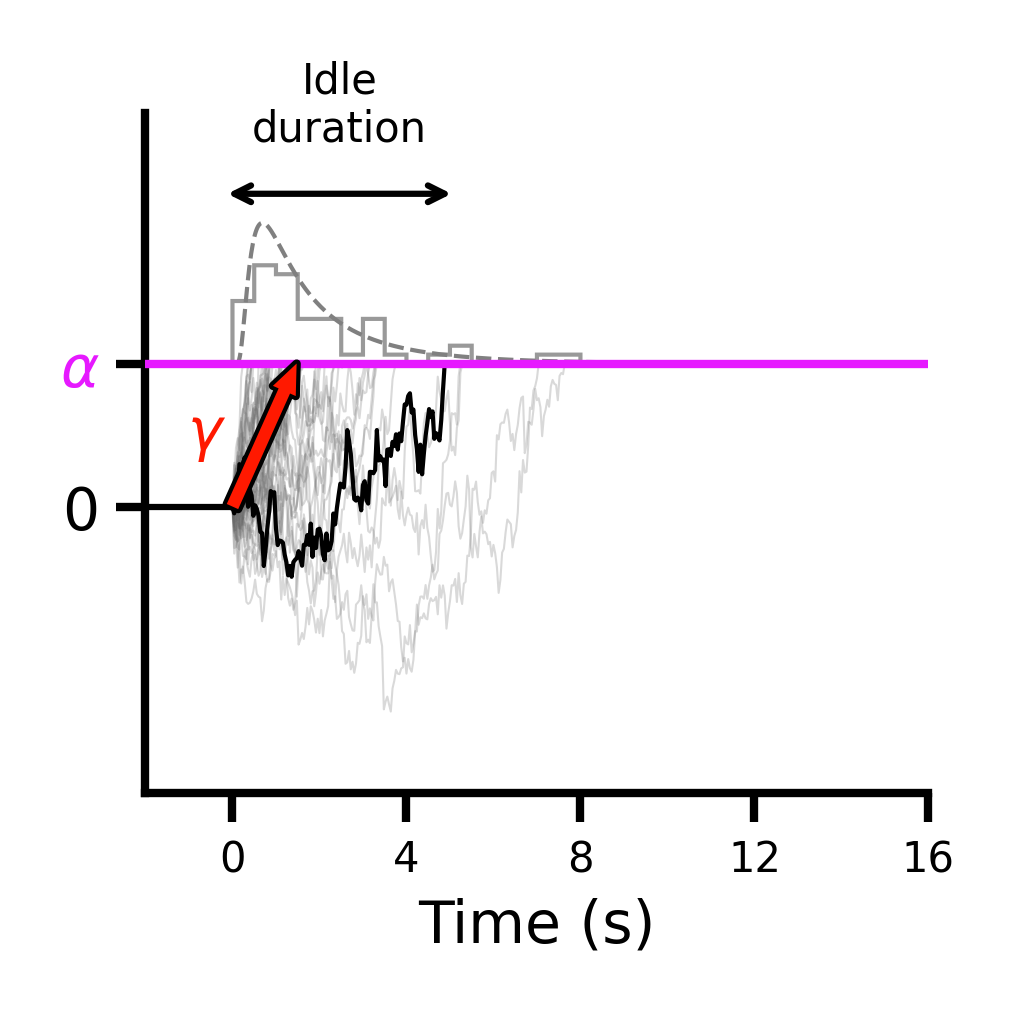

In [ ]:
def Figure4_A(ax=None, mean=.2, std=1, A=10, t0=2, N=50, alphacolor='c', gammacolor='r', base=True, xx=None, yy=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    np.random.seed(51)
    trials = [generate_trials(mean, std, A, 0) for _ in range(N)]

    example_plot = True
    for dv in trials:
        dv[-1] = A
        x = np.arange(len(dv))/25
        y = dv
        if base:
            if 4*25 <= len(y) < 5*25 and example_plot:
                ax.plot(x, y, c='k', lw=0.5, zorder=4)
                example_plot = False

                # idle time arrow
                ax.annotate(text='', xy=(-.5, 17.5), xytext=(len(y)/25+.5, 17.5), arrowprops=dict(arrowstyle='<->', lw=0.75), fontsize=5, zorder=5)
                ax.annotate(text='Idle\nduration', xy=(0, 0), xytext=(len(y)/50, 22.5), ha='center', va='center',
                            xycoords='data', fontsize=5, zorder=5)
                
        ax.plot(x, y, c='dimgray', alpha=.25, zorder=3, lw=.25,)

    waits = np.array([len(t)/25 for t in trials], dtype=np.float64)

    waitmean = A / mean * np.tanh(mean * A)  #  + t0
    ax.axhline(A, c=alphacolor, zorder=5, lw=1)
    ax.set_yticks([0, A])
    ax.set_yticklabels([0, r'$\alpha$'], fontsize=7)
    ax.get_yticklabels()[1].set_color(alphacolor)
    ax.set_xlabel('Time (s)')
    ax.set_ylim(-16, 22)
    ax.set_xlim(-2, 16)
    ax.set_xticks([0, 4, 8, 12, 16])
    ax.plot((0, -t0), (0, 0), c="k", zorder=5, lw=.75)
    # space_axes(ax)


    # gamma arrow
    # ax.text(waitmean/50-1, A/2, r'$\gamma$', ha="center", va="center", rotation=0, size=7, color=gammacolor, zorder=5)
    ax.text(-0.6, A/2, r'$\gamma$', ha="center", va="center", rotation=0, size=7, color=gammacolor, zorder=5)
    style = "Simple, head_width=.1, tail_width=0.05, head_length=.12"
    kw = dict(arrowstyle=style)
    ax.add_patch(mpatches.FancyArrowPatch((0, 0), (waitmean/25, A),
                                           shrinkA=0, shrinkB=0, edgecolor='k',
                                            mutation_scale=30, 
                                            lw=1, zorder=9, **kw))
    
    ax.add_patch(mpatches.FancyArrowPatch((0, 0), (waitmean/25, A),
                                           shrinkA=0, shrinkB=0,
                                            mutation_scale=30, 
                                            color=gammacolor, 
                                            lw=0, zorder=10, **kw))
    
    mx = 300
    bins = np.arange(0, mx+1, .5)
    ax.hist(waits, bins=bins, color='gray',
             alpha=.8, zorder=4, histtype="step", lw=.5,
             bottom=A,
             weights=np.ones_like(waits) / len(waits) *25,
             )
    
    p, _ = wald_fit(waits)
    x = np.linspace(0.01, 20, 1000)

    if base:
        ax.plot(x, A+Wald_pdf(x, *p)*15, 'gray', lw=.5, ls='--')
        return x, Wald_pdf(x, *p)*15
    else:
        ax.plot(x, A+Wald_pdf(x, *p)*15, 'gray', lw=.5)
        ax.plot(xx, A+yy, c='gray', lw=.5, ls='--')


fig, axs = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)), dpi=600)
x, y = Figure4_A(ax=axs, A=8, mean=.2, base=True, alphacolor=plt.get_cmap('cool_r')(0.1), 
                 gammacolor=plt.get_cmap('autumn')(0.1))

# Figure4_A(ax=axs[0, 1], A=14, mean=.2, base=False, alphacolor=plt.get_cmap('cool_r')(0.9), 
#           gammacolor=plt.get_cmap('autumn')(0.1), xx=x, yy=y)
# Figure4_A(ax=axs[1, 0], A=8, mean=.1, base=False, alphacolor=plt.get_cmap('cool_r')(0.1), 
#           gammacolor=plt.get_cmap('autumn')(0.85), xx=x, yy=y)
# Figure4_A(ax=axs[1, 1], A=14, mean=.1, base=False, alphacolor=plt.get_cmap('cool_r')(0.9), 
#           gammacolor=plt.get_cmap('autumn')(0.85), xx=x, yy=y)

# x, y, l, h = axs[0, 0].get_position().bounds
# print(x, y, l, h)
# plot_wald_overlay(w1, ax=fig.add_axes([x, y, l, h]))


plt.savefig("/home/david/Desktop/code/svg/ddm.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

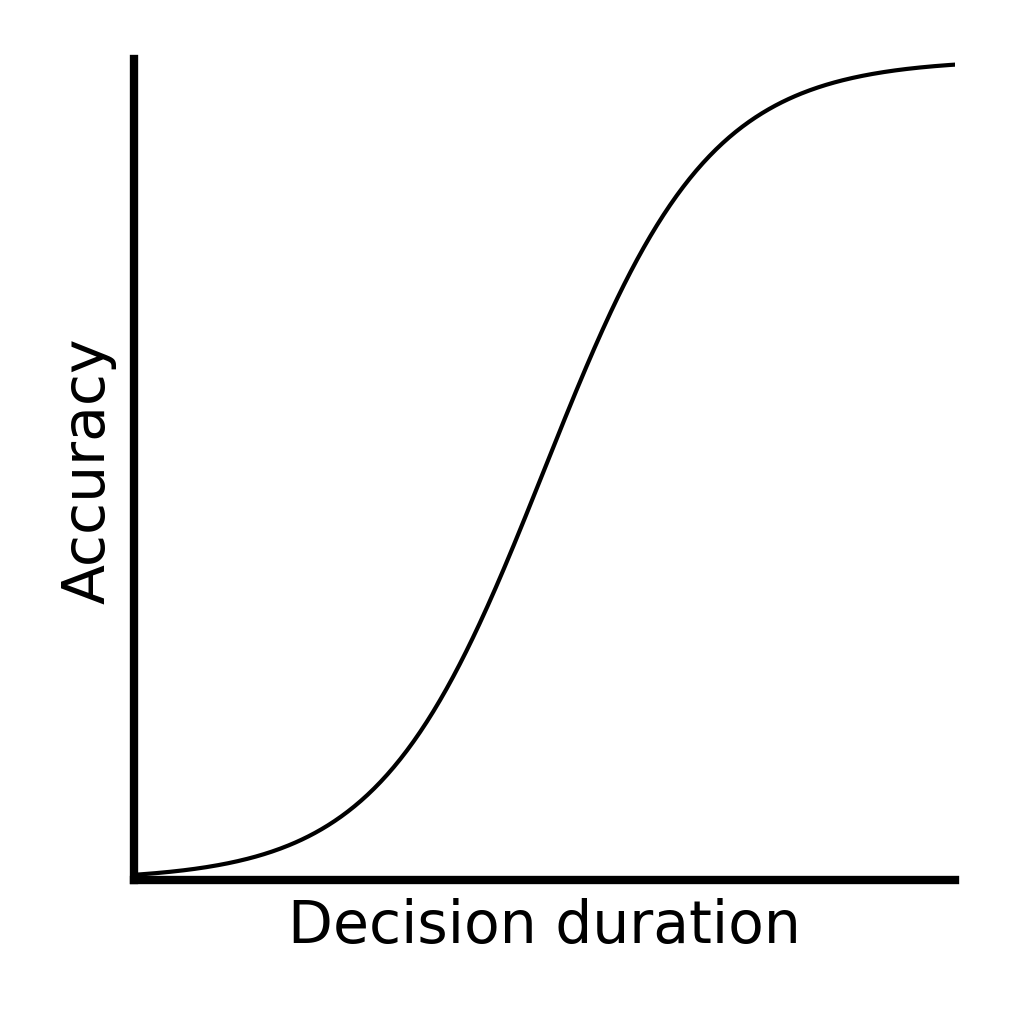

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)), dpi=600)

#sigmoid plot
x = np.linspace(-10, 10, 1000)
y = 1/(1+np.exp(-x))
axs.plot(x, y, c='k', lw=.5)
axs.set_xlim(-5, 5)
axs.set_ylim(0, 1)
axs.set_xlabel('Decision duration')
axs.set_ylabel('Accuracy')

# remove spines
axs.set_xticks([])
axs.set_yticks([])

plt.savefig("/home/david/Desktop/code/svg/SAT.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

def DDM_interactive(gamma=.2, alpha=10):
    
    fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)), dpi=600)
    std=1
    alphacolor=plt.get_cmap('cool_r')(0.1)
    gammacolor=plt.get_cmap('autumn')(0.1)
    N=50
    t0=2
    mean=gamma
    A=alpha

    np.random.seed(51)
    trials = [generate_trials(mean, std, A, 0) for _ in range(N)]

    example_plot = True
    for idx, dv in enumerate(trials):
        dv[-1] = A
        x = np.arange(len(dv))/25
        y = dv

        # if 4*25 <= len(y) < 5*25 and example_plot:
        # if idx == 20:
        #     print(idx)
        #     ax.plot(x, y, c='k', lw=0.5, zorder=4)
        #     example_plot = False

        ax.plot(x, y, c='dimgray', alpha=.25, zorder=3, lw=.25,)

    waits = np.array([len(t)/25 for t in trials], dtype=np.float64)

    waitmean = A / mean * np.tanh(mean * A)  #  + t0
    ax.axhline(A, c=alphacolor, zorder=5, lw=1)
    ax.set_yticks([0, A])
    ax.set_yticklabels([0, r'$\alpha$'], fontsize=7)
    ax.get_yticklabels()[1].set_color(alphacolor)
    ax.set_xlabel('Time (s)')
    ax.set_ylim(-16, 22)
    ax.set_xlim(-2, 16)
    ax.set_xticks([0, 4, 8, 12, 16])
    ax.plot((0, -t0), (0, 0), c="k", zorder=5, lw=.75)
    # space_axes(ax)


    # gamma arrow
    # ax.text(waitmean/50-1, A/2, r'$\gamma$', ha="center", va="center", rotation=0, size=7, color=gammacolor, zorder=5)
    ax.text(-0.6, A/2, r'$\gamma$', ha="center", va="center", rotation=0, size=7, color=gammacolor, zorder=5)
    style = "Simple, head_width=.05, tail_width=0.02, head_length=.06"
    kw = dict(arrowstyle=style)
    ax.add_patch(mpatches.FancyArrowPatch((0, 0), (waitmean/25, A),
                                           shrinkA=0, shrinkB=0, edgecolor='k',
                                            mutation_scale=30, 
                                            lw=1, zorder=9, **kw))
    
    ax.add_patch(mpatches.FancyArrowPatch((0, 0), (waitmean/25, A),
                                           shrinkA=0, shrinkB=0,
                                            mutation_scale=30, 
                                            color=gammacolor, 
                                            lw=0, zorder=10, **kw))
    
    mx = 300
    bins = np.arange(0, mx+1, .5)
    ax.hist(waits, bins=bins, color='gray',
             alpha=.8, zorder=4, histtype="step", lw=.5,
             bottom=A,
             weights=np.ones_like(waits) / len(waits) *25,
             )
    
    p, _ = wald_fit(waits)
    x = np.linspace(0.01, 20, 1000)


    ax.plot(x, A+Wald_pdf(x, *p)*15, 'gray', lw=.5, ls='--')



interactive_plot = interactive(DDM_interactive, alpha=(1, 15, 1), gamma=(0.05, .4, 0.05))
interactive_plot

interactive(children=(FloatSlider(value=0.2, description='gamma', max=0.4, min=0.05, step=0.05), IntSlider(val…

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


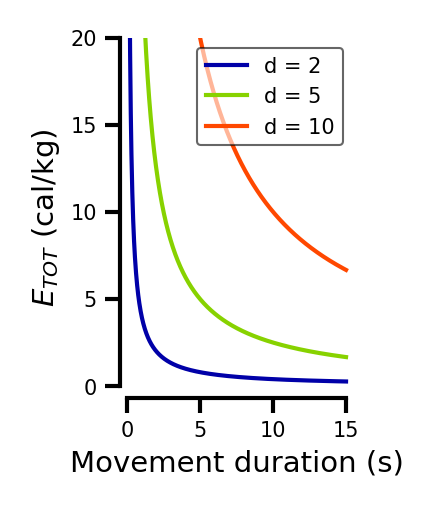

In [ ]:
# effort cost for a movement of duration T, distance D, with a belt speed of vbelt
def effort_cost(T, D=1, epsilon=1, vbelt=0, power_effort=2):
    np.seterr(divide='ignore')
    # np.seterr(multiply='ignore')
    vmax = (D - vbelt * T) / (T)
    return epsilon * T * (vmax ** power_effort)

# time cost for a movement of duration T
def time_cost(T, beta=1, power_time=3):
    return beta * T ** power_time

def Topt(D, vbelt, epsilon):
    det = epsilon**2 * vbelt**4 + 12 * epsilon * D**2
    toptsquared = (np.sqrt(det) - (epsilon * vbelt**2)) / 6
    return np.sqrt(toptsquared)


def effort(ax=None, D=.94, vbelt=0, epsilon=1, beta=1, power_effort=2, power_time=3):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(cm2inch(3), cm2inch(4)))

    t = np.linspace(0, 15, 1000)
    for D, color in zip([2, 5, 10], ['#0000A8', '#87D200', '#FF4800']):
        ax.plot(t, effort_cost(t, D, epsilon, vbelt, power_effort), label=f'd = {D}', c=color)  # label=r'$C_M$, $\varepsilon$=1, $\rho$=2'


    ax.set_xlabel('Movement duration (s)')
    ax.set_ylabel(r'$E_{TOT}$ (cal/kg)')
    ax.set_ylim(0, 20)
    ax.set_yticks([0, 5, 10, 15, 20])
    ax.set_xlim(0, 15)
    ax.set_xticks([0, 5, 10, 15])
    space_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='best',# bbox_to_anchor=(0.4, 1), 
              frameon=True, fontsize=5, markerscale=1, 
              edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)



effort()

plt.savefig("/home/david/Desktop/code/svg/effort.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

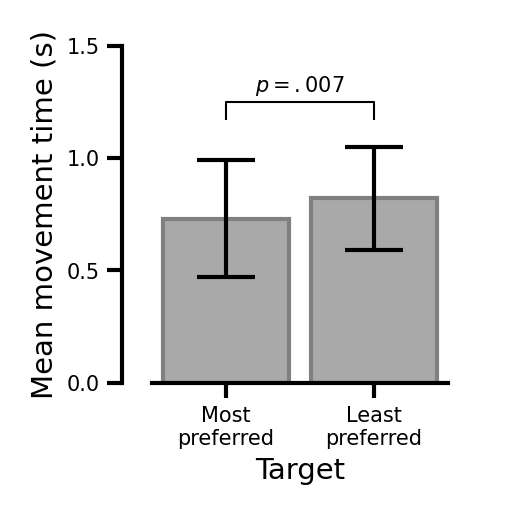

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
# Data
categories = ['Most\npreferred', 'Least\npreferred']
means = [0.73, 0.82]
std_devs = [0.26, 0.23]

# Bar plot with error bars representing standard deviation
ax.bar(categories, means, yerr=std_devs, color='gray', width=.85, facecolor='darkgray', edgecolor='gray', lw=1, capsize=7)
ax.set_xlabel('Target')
ax.set_ylabel('Mean movement time (s)')

ax.set_xlim(-.5, 1.5)
ax.set_ylim(0, 1.5)
ax.set_yticks([0, 0.5, 1, 1.5])

space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)

barplot_annotate_brackets(ax, 0, 1, r"$p=.007$", [0, 1], [1.1, 1.1], maxasterix=None)



plt.savefig("/home/david/Desktop/code/svg/sackaloo.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

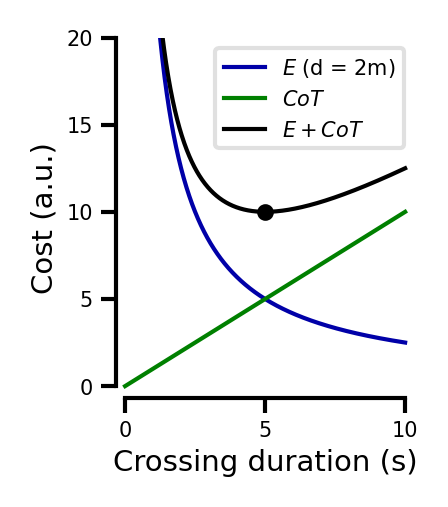

In [ ]:

def effort_cost(T, D=1, alpha=1, vbelt=0, power_effort=1):
    np.seterr(divide='ignore', invalid='ignore')
    vmax = (D - vbelt * T) / (T)
    return alpha * T * (vmax ** power_effort)

def time_cost(T, beta=1, power_time=1):
    return beta*T ** power_time


def plot_model(D=5, vbelt=0, alpha=1, beta=1, power_effort=2, power_time=1):
    fig, ax = plt.subplots(1, 1, figsize=(cm2inch(3.5), cm2inch(4)))
    T = np.linspace(0, 10, 1000)
    ax.plot(T, effort_cost(T, D, alpha, vbelt, power_effort), label='$E$ (d = 2m)', color='#0000A8')
    ax.plot(T, time_cost(T, beta, power_time), label=r'$CoT$', color='g')
    ax.plot(T, effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time), label=r'$E + CoT$', color='k')
    # argmin of total cost
    ax.plot(T[np.nanargmin(effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time))], 
            np.nanmin(effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time)),
            'o', color='k', markersize=3)

    ax.set_xlabel('Crossing duration (s)')
    ax.set_ylabel('Cost (a.u.)')
    ax.legend()
    ax.set_ylim(0, 20)
    ax.set_yticks([0, 5, 10, 15, 20])
    ax.set_xlim(0, 10)
    ax.set_xticks([0, 5, 10])

    space_axes(ax)


plot_model()


plt.savefig("/home/david/Desktop/code/svg/tradeoff.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

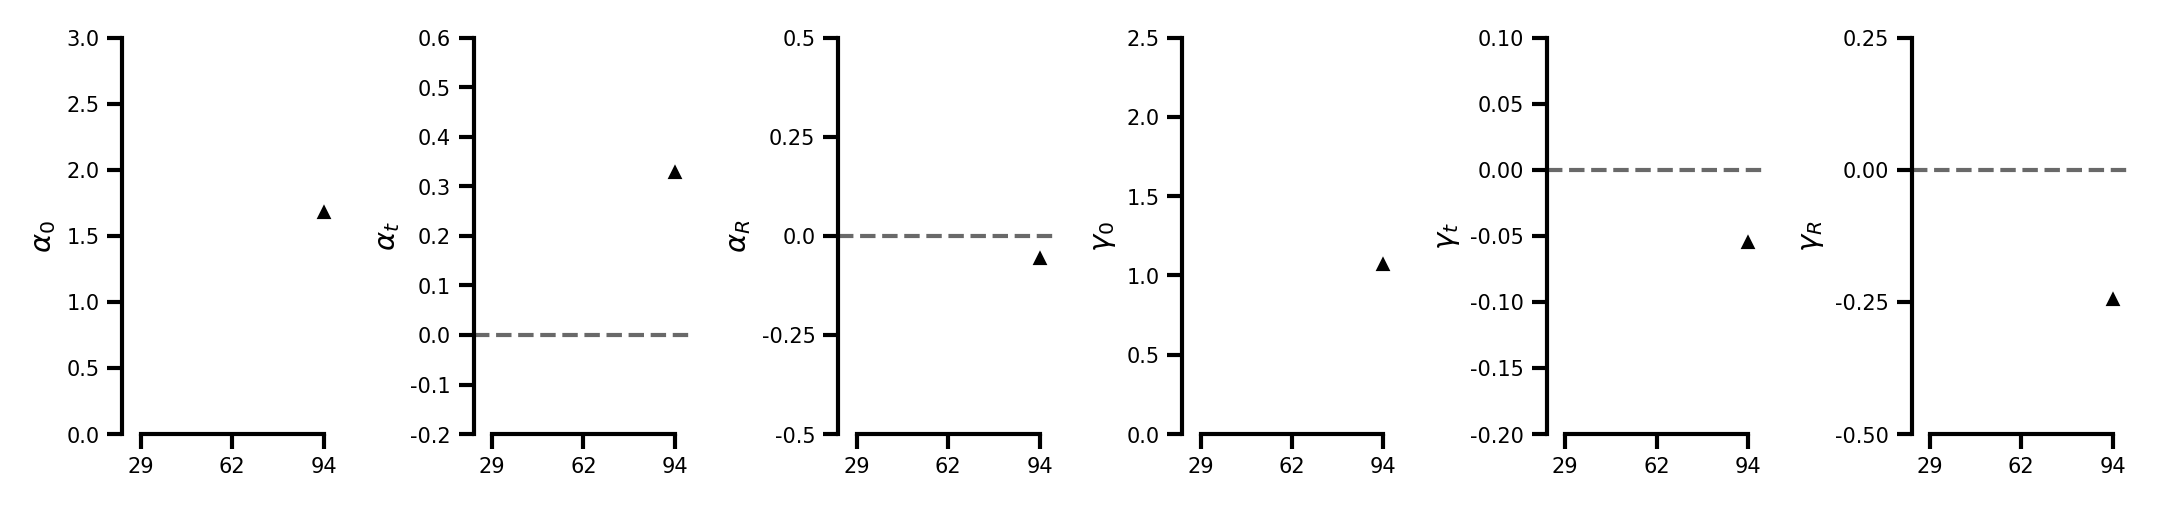

In [ ]:
def Figure4F(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    
    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_alpha, color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(0, 3)
    ax.set_ylabel(r'$\alpha_0$')
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)


def Figure4G(ax=None,show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    
    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_alpha_t, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    


    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-.2, .6)
    ax.set_ylabel(r'$\alpha_t$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)


def Figure4H(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_alpha_u, color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.5, .5)
    ax.set_yticks([-0.5, -.25, 0, .25, 0.5])
    ax.set_yticklabels(["-0.5", -.25, "0.0", .25, "0.5"])
    ax.set_ylabel(r'$\alpha_u$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)


def Figure4I(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    
    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_gamma, color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(0, 2.5)
    ax.set_ylabel(r'$\gamma_0$')
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)


def Figure4J(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))


    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_gamma_t, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    

    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.2, .1)
    ax.set_ylabel(r'$\gamma_t$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)


def Figure4K(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))


    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_gamma_u, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.5, 0.25)
    ax.set_yticks([-0.5, -.25, 0, .25])
    ax.set_ylabel(r'$\gamma_u$')
    
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)


fig, axs = plt.subplots(1, 6, figsize=(cm2inch(18), cm2inch(4)))
Figure4F(axs[0])
Figure4G(axs[1])
Figure4H(axs[2])
Figure4I(axs[3])
Figure4J(axs[4])
Figure4K(axs[5])



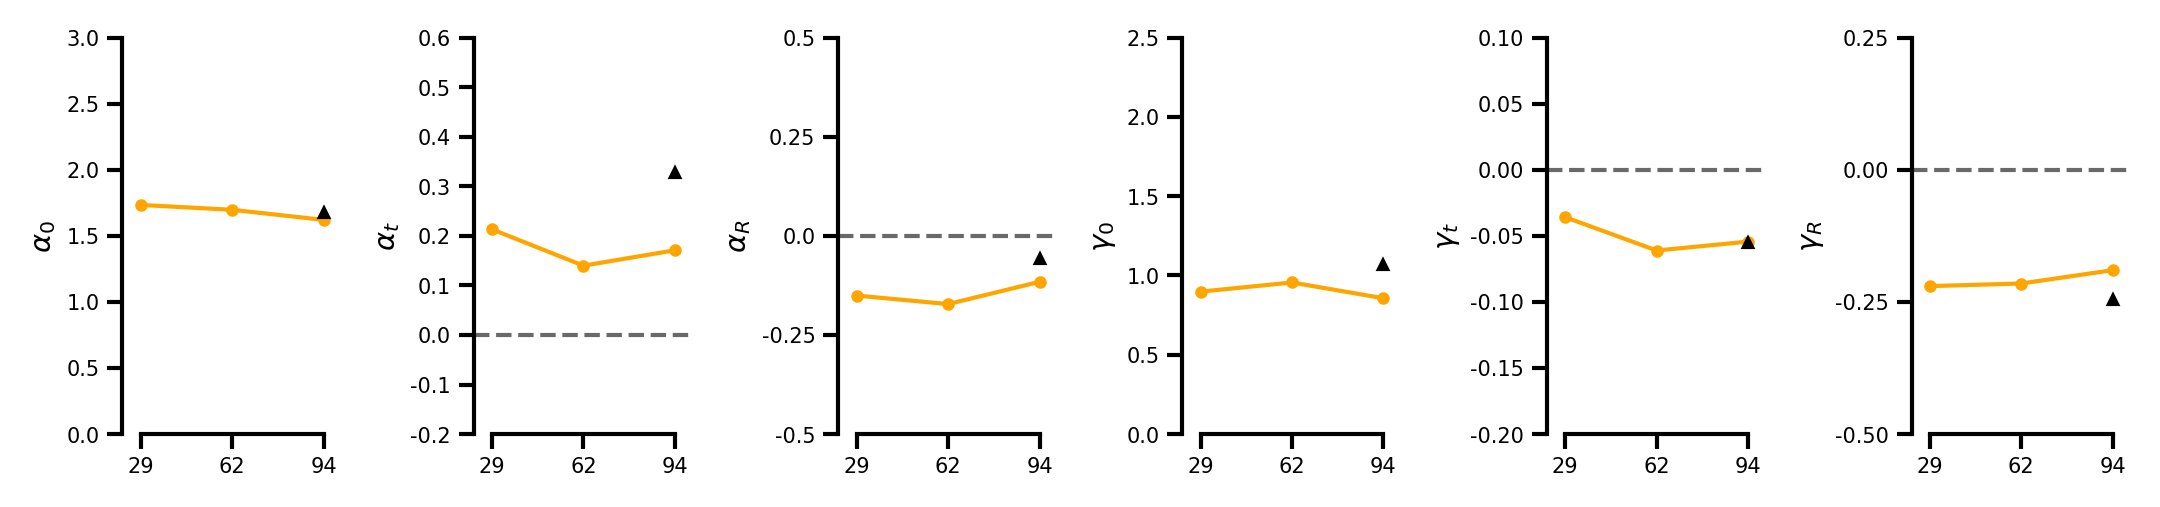

In [ ]:
def Figure4F(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [alpha_0[animal]["60"], alpha_0[animal]["90"], alpha_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5, label='Example rat')

    
    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_alpha, color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(0, 3)
    ax.set_ylabel(r'$\alpha_0$')
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)


def Figure4G(ax=None,show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:


        if animal == 'RatM00':
            ax.plot([0, 1, 2], [alpha_t[animal]["60"], alpha_t[animal]["90"], alpha_t[animal]["120"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    
    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_alpha_t, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    


    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-.2, .6)
    ax.set_ylabel(r'$\alpha_t$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)


def Figure4H(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [alpha_u[animal]["60"], alpha_u[animal]["90"], alpha_u[animal]["120"]], 
                        color=rat_markers[animal][0], label='Example rat', marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)


    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_alpha_u, color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.5, .5)
    ax.set_yticks([-0.5, -.25, 0, .25, 0.5])
    ax.set_yticklabels(["-0.5", -.25, "0.0", .25, "0.5"])
    ax.set_ylabel(r'$\alpha_u$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)

def Figure4I(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [gamma_0[animal]["60"], gamma_0[animal]["90"], gamma_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5, label='Example rat')

    
    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_gamma, color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(0, 2.5)
    ax.set_ylabel(r'$\gamma_0$')
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)


def Figure4J(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:

        if animal == 'RatM00':
            ax.plot([0, 1, 2], [gamma_t[animal]["60"], gamma_t[animal]["90"], gamma_t[animal]["120"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    

    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_gamma_t, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    

    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.2, .1)
    ax.set_ylabel(r'$\gamma_t$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)


def Figure4K(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [gamma_u[animal]["60"], gamma_u[animal]["90"], gamma_u[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_gamma_u, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.5, 0.25)
    ax.set_yticks([-0.5, -.25, 0, .25])
    ax.set_ylabel(r'$\gamma_u$')
    
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)

fig, axs = plt.subplots(1, 6, figsize=(cm2inch(18), cm2inch(4)))
Figure4F(axs[0])
Figure4G(axs[1])
Figure4H(axs[2])
Figure4I(axs[3])
Figure4J(axs[4])
Figure4K(axs[5])


# # This is a hack to get the legend to not mess up the spacing
# handles, labels = axs[0].get_legend_handles_labels()
# unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
# fig.legend(*zip(*unique), loc='upper center',# bbox_to_anchor=(0.01, 0.99), 
#                             frameon=False, fontsize=5, markerscale=1, 
#                             edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

In [ ]:
ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))

for name, val in zip([r'$\alpha_0$', r'$\alpha_t$', r'$\alpha_u$', r'$\gamma_0$', r'$\gamma_t$', r'$\gamma_u$'], 
                     [ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u]):
    print(name, val)

$lpha_0$ 1.6749019366658602
$\alpha_t$ 0.32652823486284416
$\alpha_R$ -0.05871907890528583
$\gamma_0$ 1.0650098929093814
$\gamma_t$ -0.055303904901337214
$\gamma_R$ -0.24711719272673832


p_value_20_0: 0.5009 p_value_0_rev20: 0.3765 p_value_20_rev20: 0.0627
p_value_20_0: 0.6248 p_value_0_rev20: 0.5612 p_value_20_rev20: 0.2427
p_value_20_0: 1.0 p_value_0_rev20: 1.0 p_value_20_rev20: 1.0
p_value_20_0: 0.5037 p_value_0_rev20: 0.1233 p_value_20_rev20: 0.3527
p_value_20_0: 0.8429 p_value_0_rev20: 0.0626 p_value_20_rev20: 0.1085
p_value_20_0: 0.7538 p_value_0_rev20: 1.0 p_value_20_rev20: 0.4991


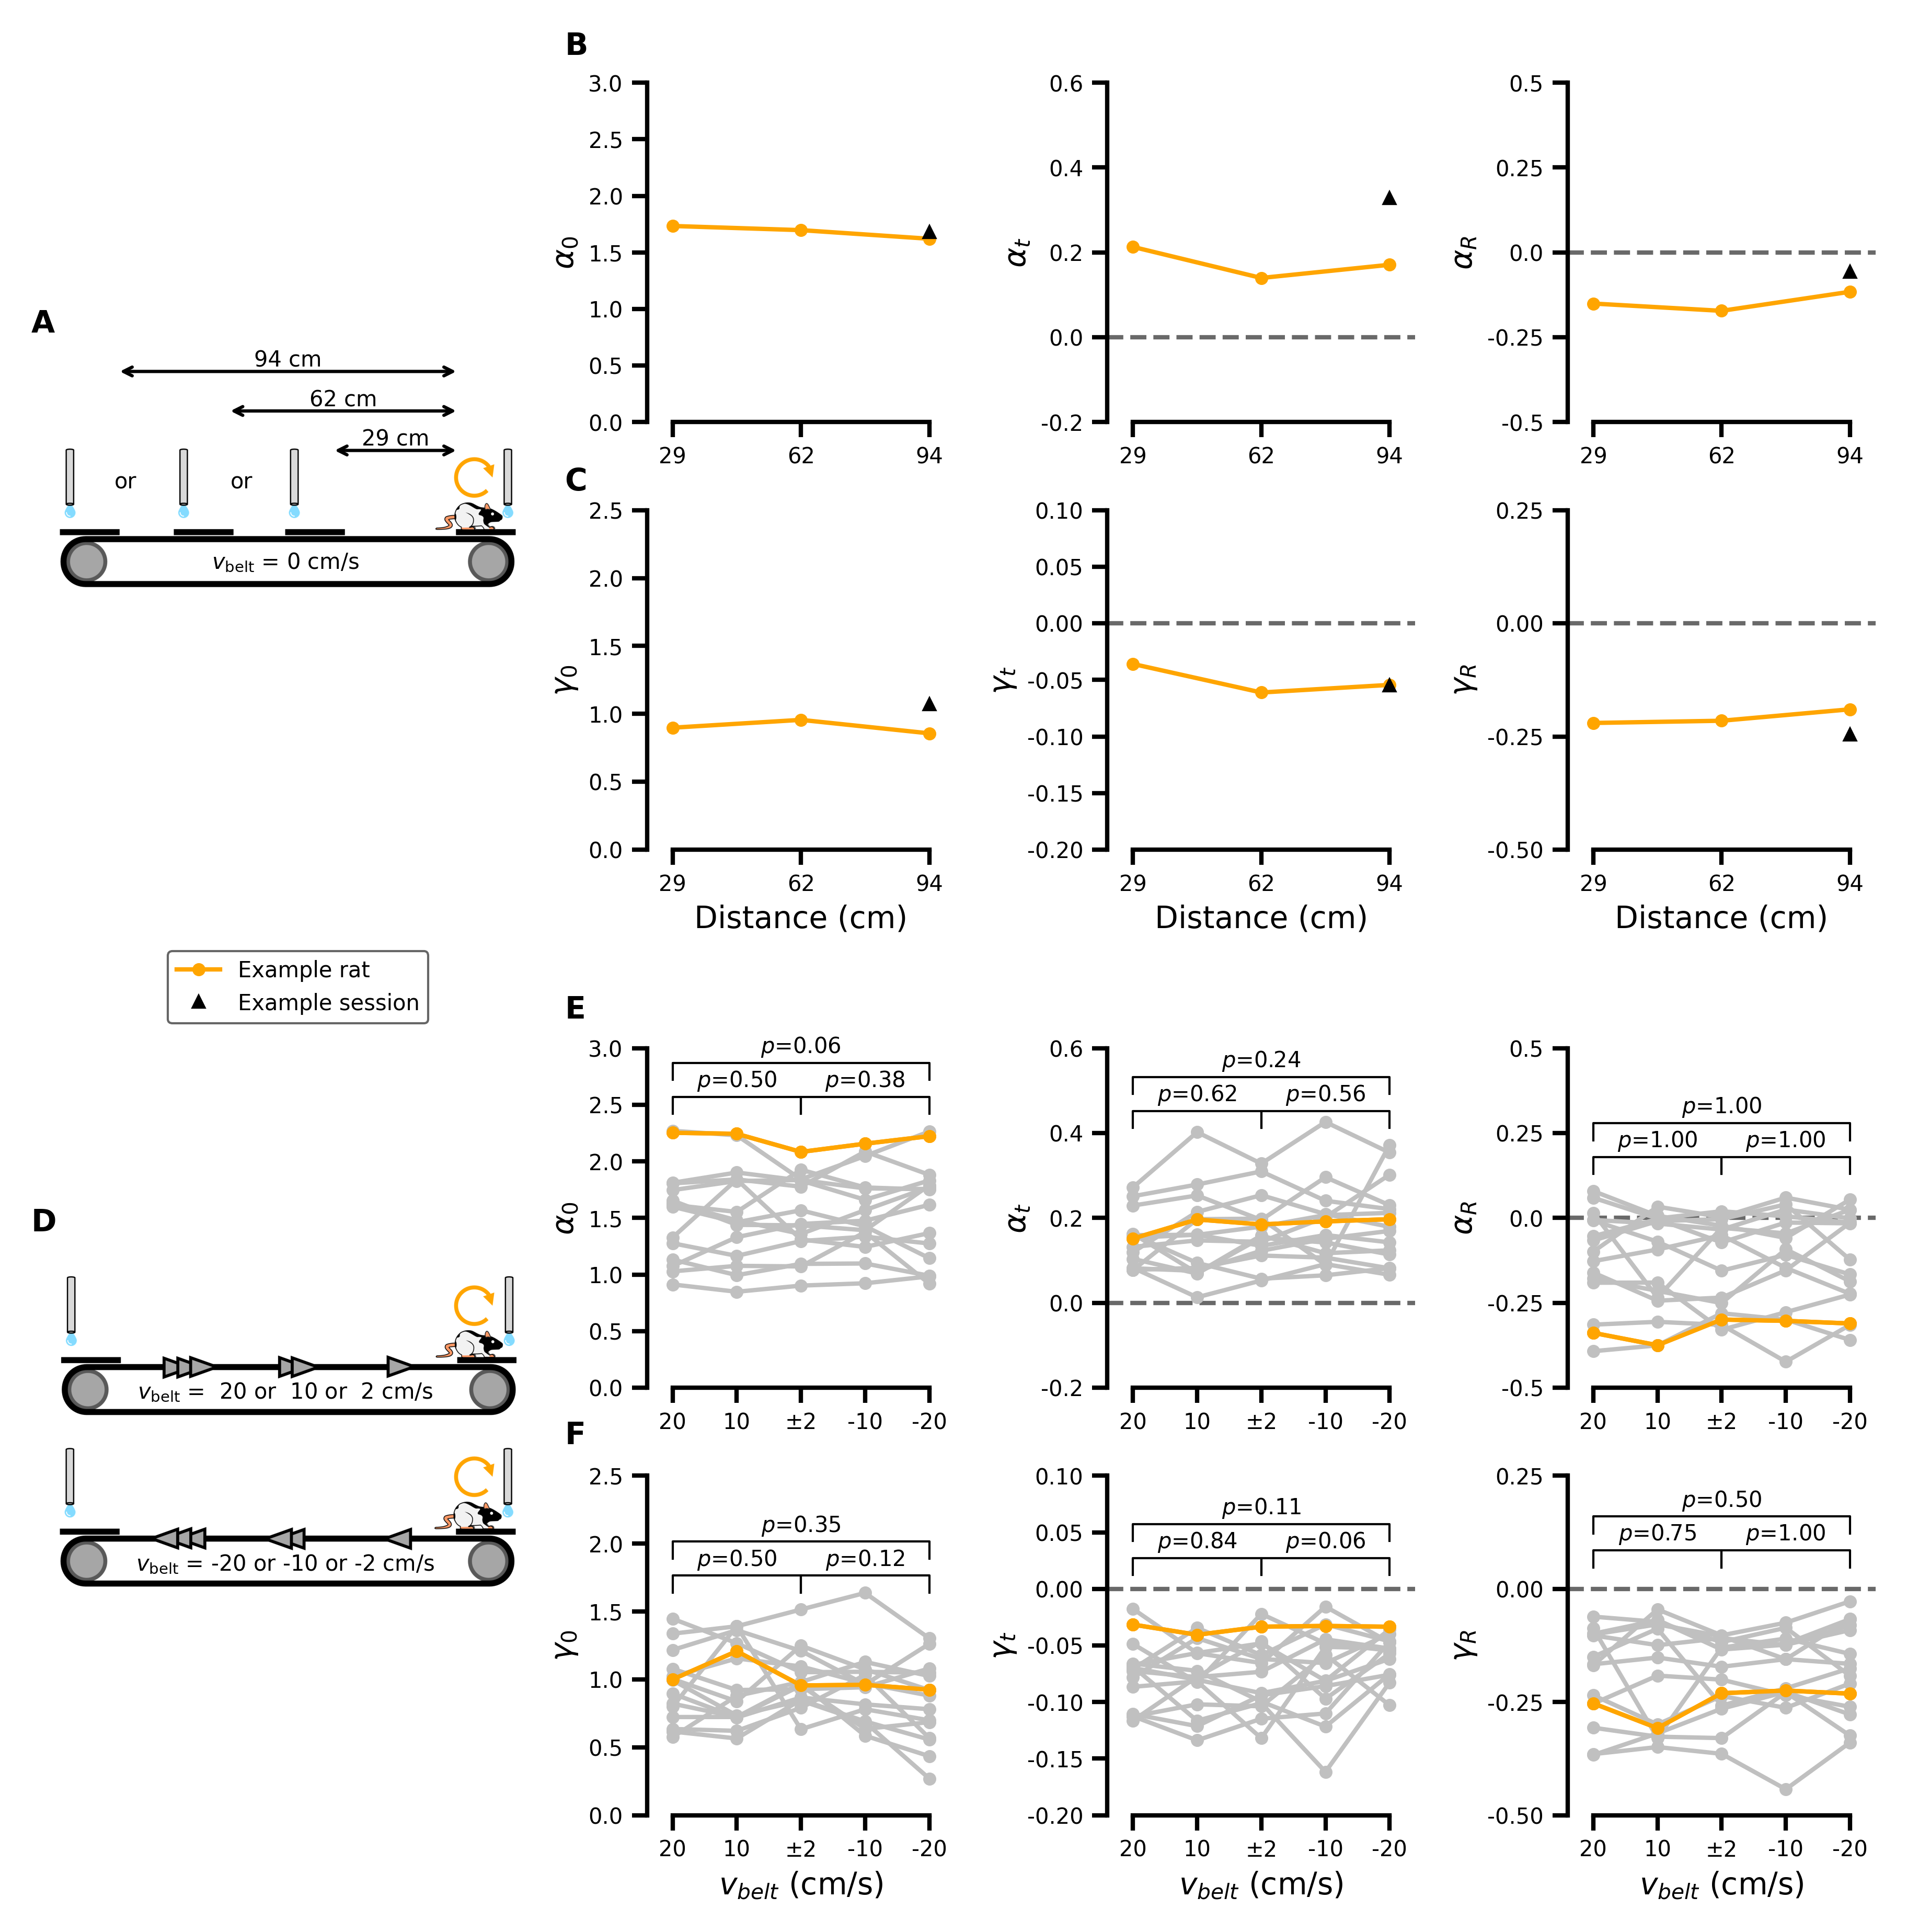

In [ ]:

fig = plt.figure(figsize=(cm2inch(18), cm2inch(15)), 
                 constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(5, 6, width_ratios=[.5, 1.5, 1, 1, 1, .5], height_ratios=[1, 1, .1, 1, 1])

distance_schematic = plt.subplot(gs0[0:2, 1])
fit_alpha_0_distance = plt.subplot(gs0[0, 2])
fit_alpha_t_distance = plt.subplot(gs0[0, 3])
fit_alpha_u_distance = plt.subplot(gs0[0, 4])

fit_gamma_0_distance = plt.subplot(gs0[1, 2])
fit_gamma_t_distance = plt.subplot(gs0[1, 3])
fit_gamma_u_distance = plt.subplot(gs0[1, 4])


vbelt_schematic = plt.subplot(gs0[3:5, 1])
fit_alpha_0_vbelt = plt.subplot(gs0[3, 2])
fit_alpha_t_vbelt = plt.subplot(gs0[3, 3])
fit_alpha_u_vbelt = plt.subplot(gs0[3, 4])

fit_gamma_0_vbelt = plt.subplot(gs0[4, 2])
fit_gamma_t_vbelt = plt.subplot(gs0[4, 3])
fit_gamma_u_vbelt = plt.subplot(gs0[4, 4])

Figure2E(ax=distance_schematic)
Figure2J(ax=vbelt_schematic)

Figure4F(ax=fit_alpha_0_distance)
Figure4G(ax=fit_alpha_t_distance)
Figure4H(ax=fit_alpha_u_distance)
Figure4I(ax=fit_gamma_0_distance, show_xlabel=True)
Figure4J(ax=fit_gamma_t_distance, show_xlabel=True)
Figure4K(ax=fit_gamma_u_distance, show_xlabel=True)

Figure4L(ax=fit_alpha_0_vbelt)
Figure4M(ax=fit_alpha_t_vbelt)
Figure4N(ax=fit_alpha_u_vbelt)
Figure4O(ax=fit_gamma_0_vbelt, show_xlabel=True)
Figure4P(ax=fit_gamma_t_vbelt, show_xlabel=True)
Figure4Q(ax=fit_gamma_u_vbelt, show_xlabel=True)


figuresLabels={"A":[0.08, .85], "B":[0.32, 1], "C":[0.32, .765], 
                "D":[0.08, .365], "E":[0.32, .48], "F":[0.32, .25],
               }

for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1],
             label, figure=fig, 
             weight='bold', fontsize=7, ha='left', va='bottom')
    
handles, labels = fit_alpha_u_distance.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
fig.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.2, .5), 
                            frameon=True, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w', 
                            # title='Legend for all figures:     ', title_fontsize=5
                            ).get_frame().set_linewidth(.5)

# plt.savefig("/home/david/Desktop/code/Figure_4_2.pdf", facecolor='w', 
#         edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)
plt.savefig("/home/david/Desktop/code/svg/Figure_3onlyratexample.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)